# Chronos Test

In this example, we will test Chronos on canonical geoscientific data sets chosen to be representative of geoscience/geophysics:
1. earthquake catalogs from SoCal
2. earthquake ground motion waveforms
3. near surface properties (seismic velocities, temperature, soil moisture)
4. ice velocity from greenland
5. GPS positions along a plate boundary that captures seasons and tectonic loading

The data has been prepared as CSV files with times series.
The forescasts are added to the CSV files under key attributes "Chronos-zero-shot".

Limitations by [Chronos](https://arxiv.org/pdf/2403.07815). Chronos uses large language models at its core for forecasting time series. The time series is "tokenized" to convert from an array of floats into contect tokens.


By Marine Denolle (mdenolle@uw.edu)


In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [2]:
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import pandas as pd
import numpy as np


# Set the font style and size
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.serif': ['DejaVu Sans'],
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})


In [ ]:
# benchmarking with ARIMA
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Assuming df is your DataFrame and 'datetime' is your datetime column
# df["datetime"] = pd.to_datetime(df["datetime"])
# df.set_index("datetime", inplace=True)

# # Assuming 'value' is the column you want to forecast
# data = df['value']

# Fit ARIMA model
# model = ARIMA(data, order=(5, 1, 0))  # (p, d, q) order, adjust as needed
# model_fit = model.fit()

# # Make predictions
# forecast_steps = 10  # Number of steps to forecast
# forecast = model_fit.forecast(steps=forecast_steps)

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(data, label='Actual')
# plt.plot(forecast, label='Forecast', color='red')
# plt.legend()
# plt.show()

# # Print forecasted values
# print(forecast)

In [4]:
n_timeseries = 20

In [5]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

TypeError: ChronosConfig.__init__() got an unexpected keyword argument 'input_patch_size'

In [6]:
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models

ImportError: cannot import name 'ChronosBoltPipeline' from 'chronos' (/home/mdenolle/miniconda/envs/quake_chronos_moirai/lib/python3.11/site-packages/chronos/__init__.py)

Some functions

In [6]:
def reshape_time_series(df, name_of_target="count" ,n_timeseries=20, duration_years=2):
    """
    Generate a list of time series from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing a 'datetime' column.
    n_timeseries (int): Number of time series to generate.
    duration_years (int): Duration of each time series in years.
    resample_period (str): Resampling period (e.g., 'D' for daily).

    Returns:
    list: A list of DataFrames, each containing a time series.
    pd.DataFrame: A wide-format DataFrame containing the time series.
    """
    df_list = [pd.DataFrame() for _ in range(n_timeseries)]
    kk = 0
    while kk < n_timeseries:
        start_date = df["datetime"].sample().values[0]
        start_date = pd.to_datetime(start_date)
        # Create a time series for the specified duration
        end_date = start_date + pd.DateOffset(years=duration_years)
        if end_date > df["datetime"].max():
            continue    # Skip if the end date exceeds the maximum date in the catalog
        # Create a time series from the catalog and select only the date time and target columns
        time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)][["datetime", name_of_target]]
        time_series = time_series.set_index("datetime")
        # time_series = time_series.resample(resample_period).mean().interpolate() # resample and interpolate
        time_series = time_series.ffill()#(method="ffill") # forward fill
        time_series = time_series.bfill()#(method="bfill") # backward fill
        time_series = time_series.reset_index()# reset index to keep datetime as a column
        # remove the "datetime" column to the time_series
        
        df_list[kk] = time_series
        kk += 1 
    df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
    for ik in range(n_timeseries):
        df_list_count[ik] = df_list[ik][name_of_target]
        df_list_count[ik] = df_list_count[ik].rename(f"target_{ik}")
    df_wide = pd.concat(df_list_count, axis=1)

    # find the sampling rate dt as the difference between the first two dates
    dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
    # convert dt to days
    dt = dt / (24 * 3600)
    print("sampling rate {:.2f} days".format(dt))

    # create a time array that is the index of the time series and convert the dae
    df_wide["time_index"] = np.arange(len(df_wide)) #* pd.Timedelta(days=dt)
    # move the last column to the first position
    cols = df_wide.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_wide = df_wide[cols]

    # rename columns to target_ID except for the first column that is a datetime
    df_wide.columns = [f"target_{i}" if i != 0 else "time_index" for i in range(len(df_wide.columns))]
    df_wide = df_wide.dropna() 
    
    return df_list, df_wide

# Example usage:
# df_list,df_wide = reshape_time_series(df, n_timeseries=20, duration_years=2, resample_period='D')

In [7]:
def predict_chronos(df, predict_length=64, n_timeseries=20):
    """
    Make predictions for the given time series data.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
    forecast_mean (np.array): The mean forecasted values for the time series.
    lower_bound (np.array): The 5% lower bound of the forecasted values.
    upper_bound (np.array): The 95% upper bound of the forecasted values.
    mean_mae (float): The mean absolute error of the forecasted values.
    no_var_mae (float): The mean absolute error assuming no change in the time series.


    """
    # Ensure df['Date'] is in datetime format
    # df['datetime'] = pd.to_datetime(df['datetime'])

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    # Calculate the split index for training
    split_index = int(len(df) - predict_length)

    # Split the data into training and evaluation sets for all selected columns
    train_data = df[columns_to_forecast].iloc[:split_index]
    eval_data = df[columns_to_forecast].iloc[split_index:]

    # Convert the training data to a higher-dimensional tensor
    train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T
    # Perform the forecasting using the training data
    forecast = pipeline.predict(
        context=train_tensor,
        prediction_length=len(eval_data),  # Predict the same length as the evaluation set
        num_samples=50,
    )

    # Take the mean across the samples (axis=1) for each time series
    forecast_mean = forecast.mean(dim=1).squeeze().numpy()
    # lower_bound = forecast.quantile(0.05, dim=1).squeeze().numpy()
    # upper_bound = forecast.quantile(0.95, dim=1).squeeze().numpy()


    mae=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae.append (np.mean(np.abs(forecast_mean[i]- eval_data[column_name].values)))
        
        # Print the MAE
        print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

    mean_mae = np.array(mae).mean()
    print(f'Mean of forecast MAEs = {mean_mae}')

    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i] - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
        # Print the MASE
        print(f'Mean Absolute Scaled Error (MASE) for {column_name}: {mase[-1]}')

    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MAEs = {mean_mase}')


    # Baseline model: ARIMA
    mae_arima=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae_arima.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
        
        # Print the MAE
        # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

    mae_arima_mean = np.array(mae_arima).mean()
    print(f'Mean of ARIMA MAEs = {mae_arima_mean}')

    return forecast,mean_mae, mean_mase, mae_arima_mean, split_index

In [8]:
import matplotlib.dates as mdates
def plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="count",filename="geo-forecast.png"):
    """
    Plot the forecasted values along with the confidence intervals.

    Parameters:
    n_timeseries (int): Number of time series to plot.
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    split_index (int): The index at which the training data ends (or context data) and evaluation (or forecast) data begins.
    forecast (np.array): The forecasted values for the time series.
    filename (str): The filename to save the plot.


    Returns:
    None


    """
    
    # Determine the number of rows and columns for the subplots
    n_timeseries = min(n_timeseries, 12)  # Cap the number of time series to 12
    nrows = (n_timeseries - 1) // 3 + 1
    ncols = min(n_timeseries, 3)

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column
    print(forecast.shape)
    forecast_mean = forecast.mean(dim=1).squeeze()
    print(forecast_mean.shape)
    lower_bound = np.percentile(forecast, 5, axis=0)
    upper_bound = np.percentile(forecast, 95, axis=0)

    # Layout the subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 16), sharex=True)
    # Flatten the 2D array of axes for easy indexing
    if n_timeseries>1:
        axes = axes.flatten()
    else:
        axes = [axes]
        


    # Split the data into training and evaluation sets for all selected columns
    # train_data = df_wide[columns_to_forecast].iloc[:split_index]
    eval_data = df_wide[columns_to_forecast].iloc[split_index:]


    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i].numpy()  - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MASEs = {mean_mase}')
    print(n_timeseries)
    # Iterate over the first n_timeseries and plot
    if n_timeseries>1:
        for i, column_name in enumerate(columns_to_forecast[0:n_timeseries]):
            # Plot the original data
            axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
            
            # Calculate the 5th and 95th percentiles for the confidence interval
            lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
            upper_bound = np.percentile(forecast[i, :, :], 95, axis=0)
            
            # Plot the forecast
            axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean[i], label='Forecast')
            
            # Plot the confidence intervals
            axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                                color='r', alpha=0.2, label='95% CI')


            # set the x-axis labels as the number of days
            # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
            axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

            # Plot the evaluation data for reference
            # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

            # Format the subplot
            axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
            axes[i].set_ylabel(field)
            axes[i].set_xlabel('Time Index')
            if i==0: axes[i].legend()

            # Apply x-tick rotation
            # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
            # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[i].tick_params(axis='x', rotation=45)
            # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            # convert the x-labels to days every month
            # axes[i].xaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        # Plot the original data
        axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
        
        # Calculate the 5th and 95th percentiles for the confidence interval
        lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
        upper_bound = np.percentile(forecast[ i, :, :], 95, axis=0)
        print(forecast_mean.shape)
        # Plot the forecast
        axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean, label='Forecast')
        
        # Plot the confidence intervals
        axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                            color='r', alpha=0.2, label='95% CI')


        # set the x-axis labels as the number of days
        # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
        axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

        # Plot the evaluation data for reference
        # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

        # Format the subplot
        axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
        axes[i].set_ylabel(field)
        axes[i].set_xlabel('Time Index')
        if i==0: axes[i].legend()

        # Apply x-tick rotation
        # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)




    # Remove empty subplots if n_timeseries < 8
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(filename)
    # also save a SVG 
    plt.savefig(filename.replace('.png','.svg'))
    plt.show()


    # add a column to df_wide with the predictions for each target_{i} labels at the rows of the evaluation data
    for i, column_name in enumerate(columns_to_forecast):
        df_wide.loc[df_wide.index[split_index:], f'forecast_{i}'] = forecast_mean[i].numpy()

    # store the new df_wide with the precition into a new CSV files that takes the filename of the original file
    df_wide.to_csv(filename.replace('.png','.csv'), index=False)

    return

In [9]:
# Quick plot
def quick_plot(df_wide,n_timeseries,field="count",dt=1):
    """
    Quick plot of the time series data.

    Parameters:
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    n_timeseries (int): Number of time series to plot.
    field (str): The field to plot.


    Returns:
    None
    """
    # Determine the number of rows and columns for the subplots
    n_timeseries2 = min(n_timeseries, 6)  # Cap the number of time series to 12
    nrows = (n_timeseries2 - 1) // 3 + 1
    ncols = min(n_timeseries2, 3)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 8))  # define the figure and subplots
    axes = axes.ravel()
    for i in range(n_timeseries2):
        # create a time axis that multiplies time_data by dt
        # Calculate the time index as the difference from the first datetime
        # df_wide['time_index'] = (df_wide['time_index'] - df_wide['time_index'].iloc[0]).dt.total_seconds() / (24 * 3600)

        # Convert the time_index to a float array
        time_index_days_float = df_wide['time_index'].values


      
        ax = axes[i]
        ax.plot(time_index_days_float, df_wide[f"target_{i+1}"], label=f"{field}_{i+1}")
        ax.set_title(f"{field} {i}")
        ax.set_xlabel("Days")
        ax.set_ylabel(field)
        plt.tight_layout()
        ax.grid()

    plt.show()

## Earthquake Data


In [10]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

datetime  count
0  2008-01-01    120
1  2008-01-02     89
2  2008-01-03    146
3  2008-01-04    166
4  2008-01-05     94

In [11]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print(dt)

1.0


## Reshape for Prediction

In [12]:
# randomly cut the long time series into n_timeseries, stored in data frames.
df_list,df_wide = reshape_time_series(df, name_of_target="count", n_timeseries=n_timeseries, duration_years=2)

sampling rate 1.00 days


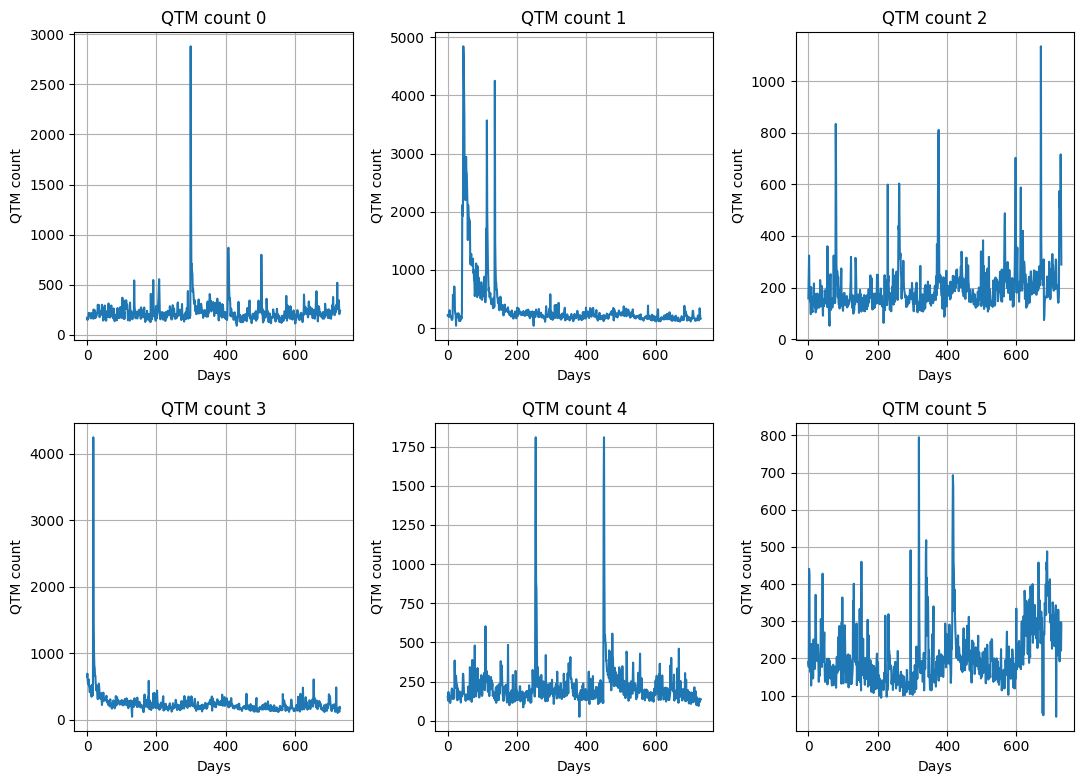

In [13]:
quick_plot(df_wide,n_timeseries,field="QTM count",dt=1)

### Predict with Chronos & Plot

Mean Absolute Error (MAE) for target_1: 56.77481508255005
Mean Absolute Error (MAE) for target_2: 38.62313914299011
Mean Absolute Error (MAE) for target_3: 89.99969911575317
Mean Absolute Error (MAE) for target_4: 44.044193744659424
Mean Absolute Error (MAE) for target_5: 32.9009735584259
Mean Absolute Error (MAE) for target_6: 76.81849002838135
Mean Absolute Error (MAE) for target_7: 53.11581516265869
Mean Absolute Error (MAE) for target_8: 41.176023960113525
Mean Absolute Error (MAE) for target_9: 50.000874280929565
Mean Absolute Error (MAE) for target_10: 29.1728835105896
Mean Absolute Error (MAE) for target_11: 67.28367757797241
Mean Absolute Error (MAE) for target_12: 164.4189429283142
Mean Absolute Error (MAE) for target_13: 124.04773950576782
Mean Absolute Error (MAE) for target_14: 48.36271023750305
Mean Absolute Error (MAE) for target_15: 303.81473302841187
Mean Absolute Error (MAE) for target_16: 30.56557273864746
Mean Absolute Error (MAE) for target_17: 107.35725092887878
Me

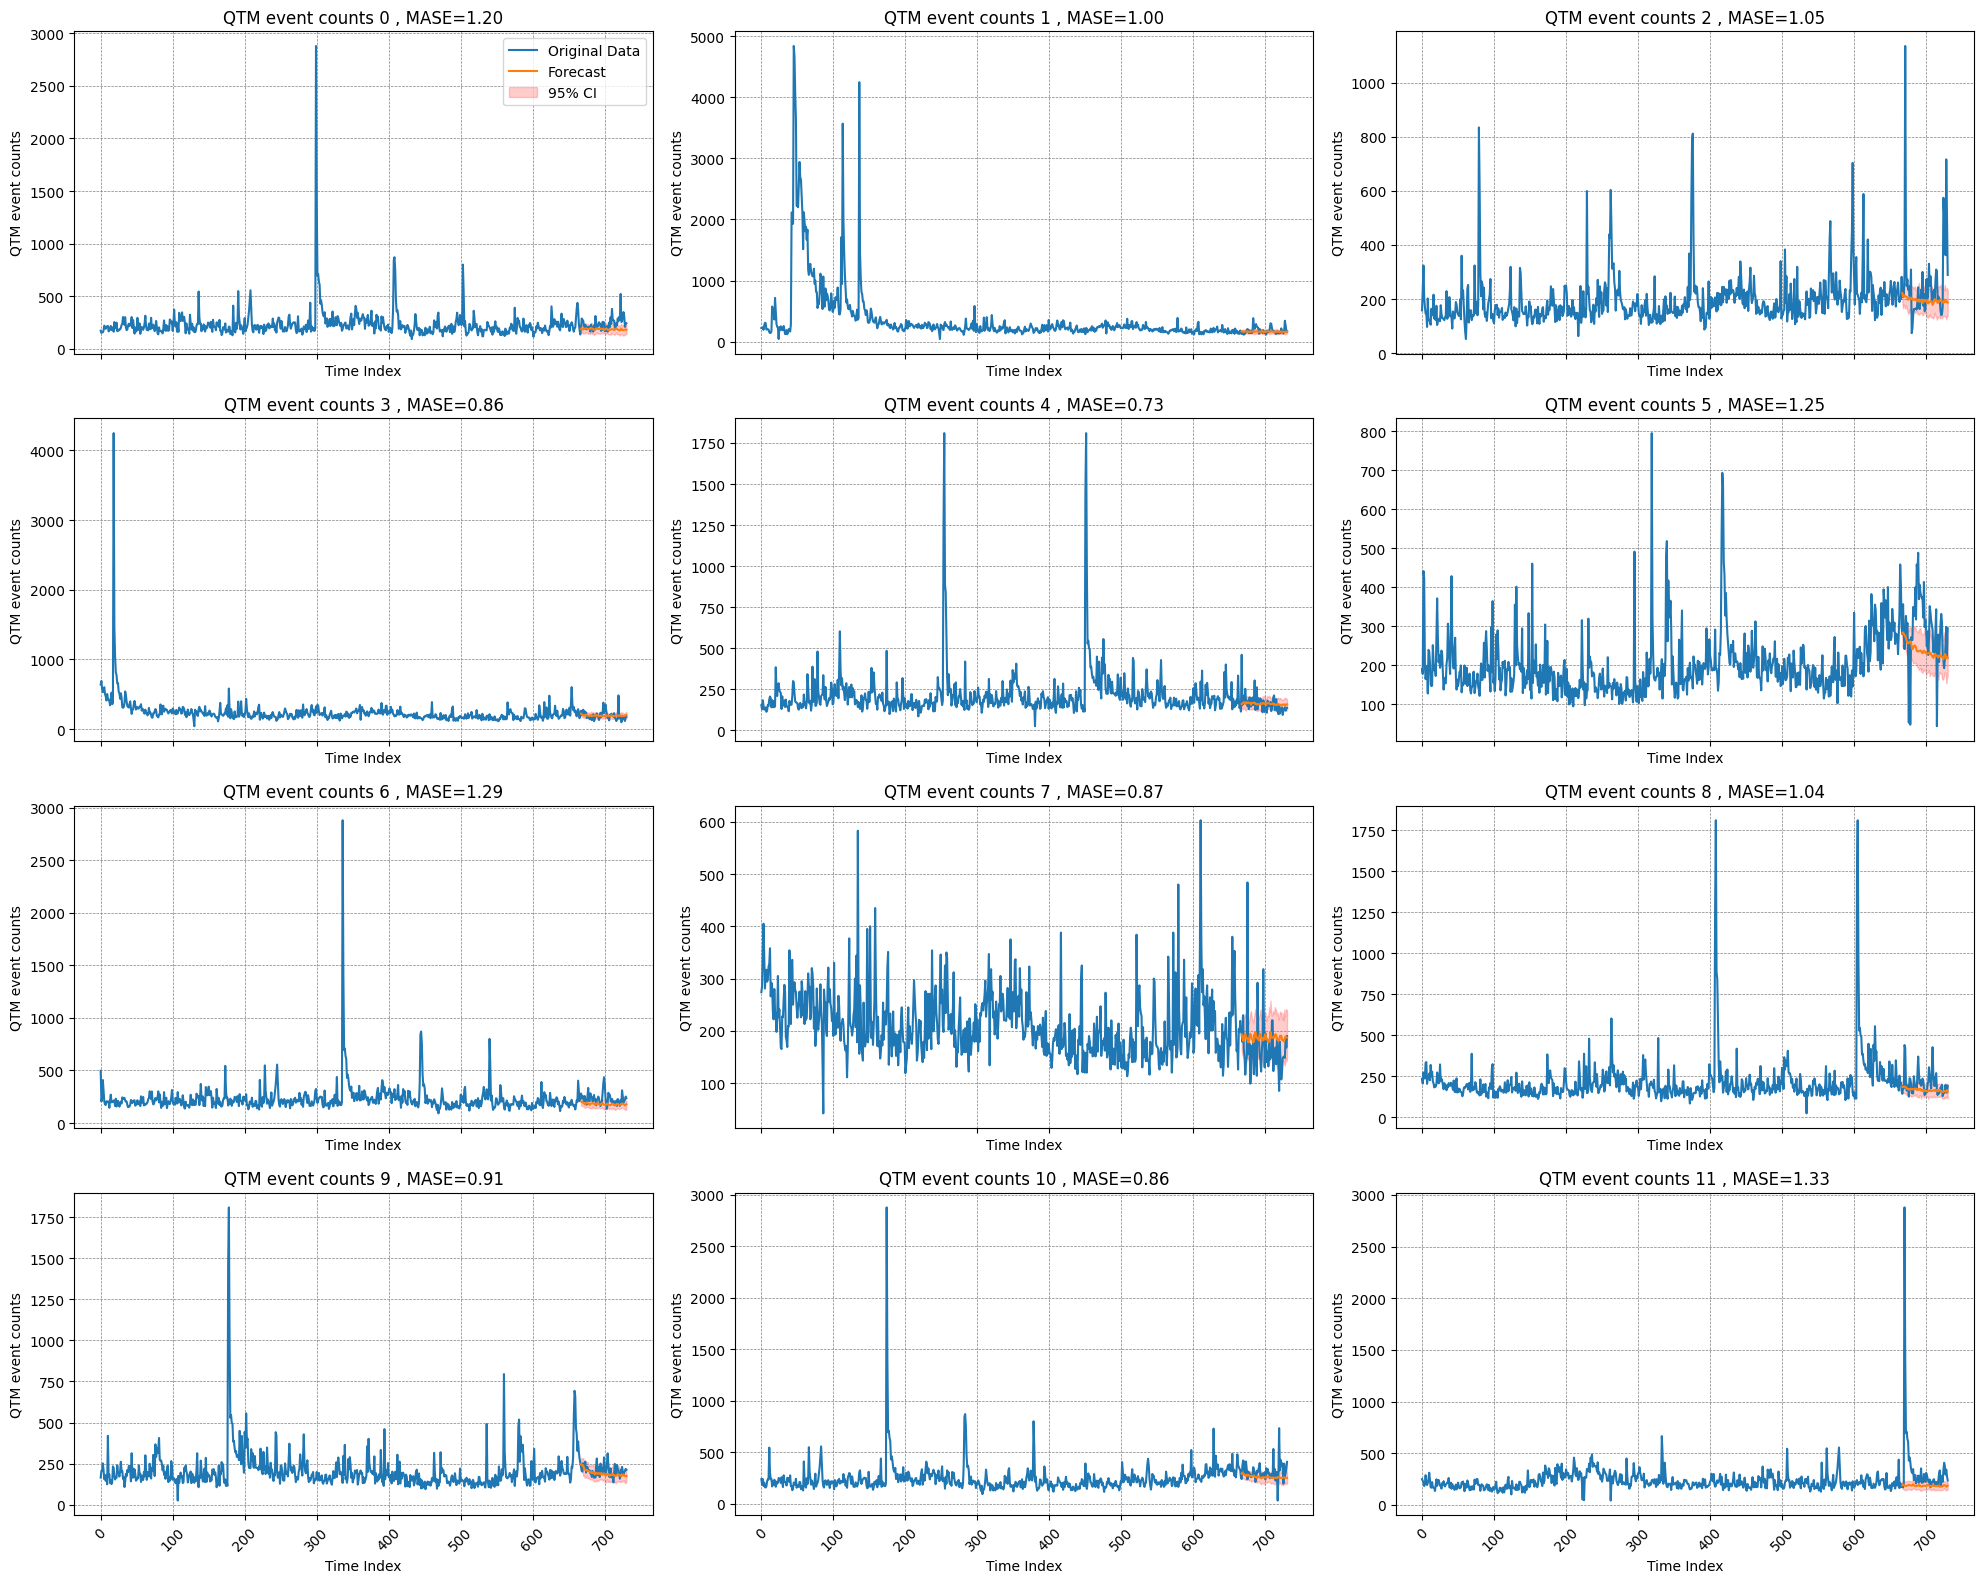

In [14]:
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="QTM event counts",filename="./plots/quake_qtm_forecast.png")
# save a vectorized plot

In [15]:
df_wide.head()

time_index  target_1  target_2  target_3  target_4  target_5  target_6  \
0           0       172     223.0     158.0       641       153     190.0   
1           1       151     223.0     232.0       691       128     177.0   
2           2       158     234.0     324.0       575       183     441.0   
3           3       157     194.0     206.0       531       150     423.0   
4           4       175     268.0     170.0       568       126     197.0   

   target_7  target_8  target_9  ...  forecast_2  forecast_3  forecast_4  \
0       497       274       236  ...         NaN         NaN         NaN   
1       205       285       207  ...         NaN         NaN         NaN   
2       238       355       274  ...         NaN         NaN         NaN   
3       409       405       247  ...         NaN         NaN         NaN   
4       300       342       237  ...         NaN         NaN         NaN   

   forecast_5  forecast_6  forecast_7  forecast_8  forecast_9  forecast_10  \
0         NaN         NaN         NaN         NaN         NaN          NaN   
1         NaN         NaN         NaN         NaN         NaN          NaN   
2         NaN         NaN         NaN         NaN         NaN          NaN   
3         NaN         NaN         NaN         NaN         NaN          NaN   
4         NaN         NaN         NaN         NaN         NaN          NaN   

   forecast_11  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 33 columns]

667    252.847593
668    238.459169
669    229.778169
670    248.267504
671    249.878638
          ...    
726    359.498810
727    361.489564
728    363.479431
729    365.612980
730    367.827727
Name: predicted_mean, Length: 64, dtype: float64
64
Mean Absolute Scaled Error (MASE) for ARIMA: 1.3803538937703104


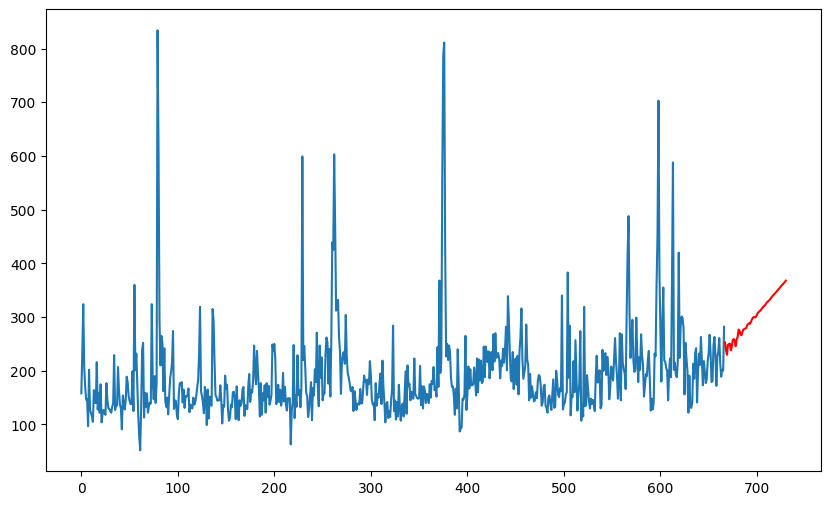

In [16]:
# benchmarking with ARIMA
# Fit ARIMA model
data = df_wide['target_3'][:split_index]
model = ARIMA(data, order=(15, 2, 0))  # (p, d, q) order, adjust as needed
model_fit = model.fit()

# Make predictions
forecast_steps = 64  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

split_index = len(df_wide['target_3'].values) - 64
print(forecast) 
# calculate the MASE between the forecast and the evaluation data
mase=[]
eval_data = df_wide['target_1'][split_index:]
print(len(df_wide['target_1'].values[split_index:]))
# Calculate and print the MASE for each time series
mase.append(np.mean(np.abs(forecast - df_wide['target_1'].values[split_index:])) / np.mean(np.abs(df_wide['target_1'].values[1:] - df_wide['target_1'].values[:-1])))
# print mase
print(f'Mean Absolute Scaled Error (MASE) for ARIMA: {mase[-1]}')

                 

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(forecast, label='Forecast', color='red')


## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [17]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [18]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["Date"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print("sampling rate {} days".format(dt))

sampling rate 8.0 days


### Reshape for prediction

In [19]:
df_wide = df
df_wide.dropna()

Date  Pixel Value (x=2500, y=8200)  Pixel Value (x=2500, y=8201)  \
0    2015-01-01                     2690.5570                     2682.3616   
1    2015-01-13                     2714.7678                     2694.3774   
2    2015-01-25                     2712.4210                     2724.5880   
4    2015-02-18                     2641.4170                     2613.6772   
5    2015-03-02                     2695.7231                     2654.4783   
..          ...                           ...                           ...   
437  2024-02-25                     2355.7673                     2317.1812   
438  2024-03-08                     2356.8071                     2318.0103   
439  2024-03-20                     2369.9165                     2318.2954   
440  2024-04-01                     2304.3186                     2255.6506   
441  2024-04-13                     2300.0273                     2244.5710   

     Pixel Value (x=2500, y=8202)  Pixel Value (x=2500, y=8203)  \
0                       2658.6174                     2606.9355   
1                       2657.5322                     2604.6094   
2                       2735.8308                     2645.3513   
4                       2577.1538                     2528.2330   
5                       2596.1223                     2527.4956   
..                            ...                           ...   
437                     2267.6526                     2218.5762   
438                     2271.4500                     2208.3280   
439                     2239.7700                     2166.4363   
440                     2209.5908                     2154.6484   
441                     2165.4233                     2103.4187   

     Pixel Value (x=2500, y=8204)  Pixel Value (x=2500, y=8205)  \
0                       2530.3400                     2432.4604   
1                       2541.0916                     2492.7390   
2                       2518.3074                     2460.4731   
4                       2444.6372                     2356.7375   
5                       2450.6010                     2383.8125   
..                            ...                           ...   
437                     2174.4893                     2119.7183   
438                     2131.2380                     2038.9028   
439                     2106.1460                     2046.7198   
440                     2079.5513                     1998.6061   
441                     2059.3809                     1990.8022   

     Pixel Value (x=2500, y=8206)  Pixel Value (x=2500, y=8207)  \
0                       2337.5603                     2238.3130   
1                       2451.3862                     2415.7693   
2                       2262.7056                     2141.2844   
4                       2280.1716                     2216.3354   
5                       2317.7700                     2231.7078   
..                            ...                           ...   
437                     2036.1709                     1886.2402   
438                     1941.8640                     1839.1848   
439                     1997.2346                     1934.0216   
440                     1931.5712                     1849.2580   
441                     1887.8052                     1750.1135   

     Pixel Value (x=2500, y=8208)  ...  Pixel Value (x=2509, y=8201)  \
0                       2131.6187  ...                     1860.1473   
1                       2235.5337  ...                     1866.2997   
2                       2034.8848  ...                     1807.4071   
4                       2187.7751  ...                     1803.6461   
5                       2069.8728  ...                     1768.4241   
..                            ...  ...                           ...   
437                     1742.2327  ...                     1555.8588   
438                     1730.7375  ...                     1584.8710   

In [20]:
# remove the first column and place the last at first position
df_wide = df_wide.drop(columns=["Date"])
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]


In [21]:
# now rename all Pixel columns to indexes except for the first one
df_wide.columns = ["time_index"] + ["target_"+str(i) for i in range(len(df_wide.columns)-1)]   

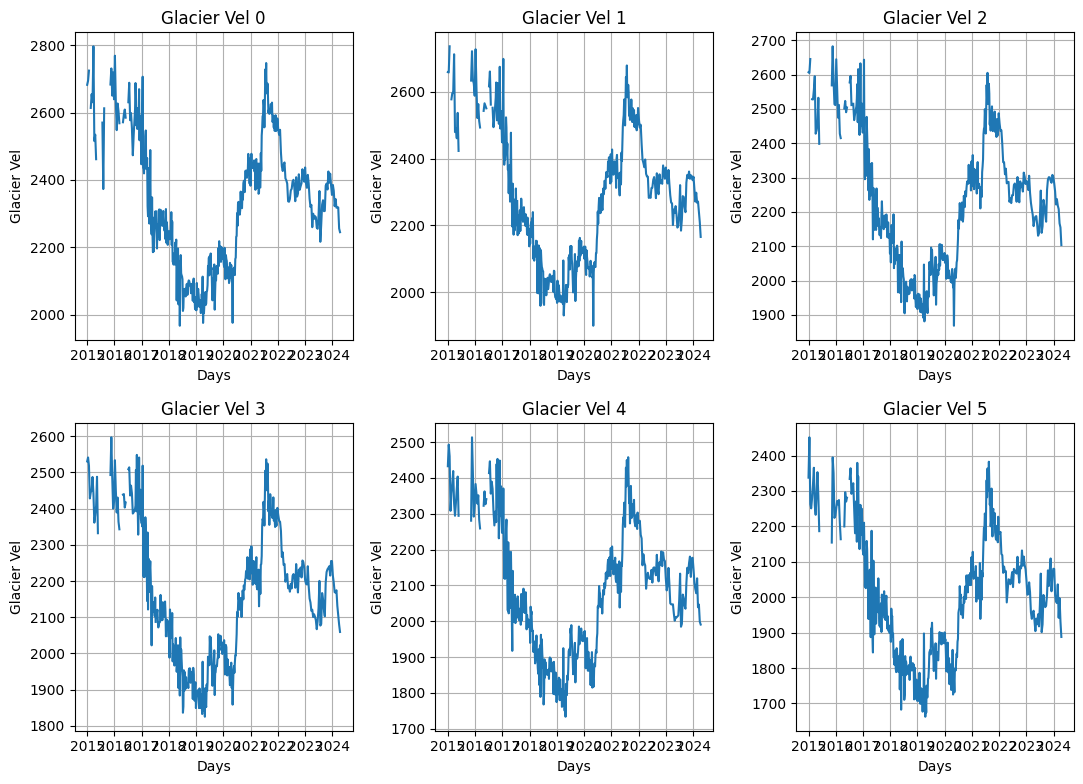

In [22]:
quick_plot(df_wide,n_timeseries,field="Glacier Vel",dt=8)

In [23]:
torch.cuda.empty_cache()
import gc
gc.collect()

20133

In [24]:
n_predict = 5
time_forecast = n_predict * dt 
print("Forecasting for {} days".format(time_forecast))

Forecasting for 40.0 days


## Predict & Plot forecasts with Chronos

Mean Absolute Error (MAE) for target_0: 54.65930015624999
Mean Absolute Error (MAE) for target_1: 61.709960156250055
Mean Absolute Error (MAE) for target_2: 73.85830453125008
Mean Absolute Error (MAE) for target_3: 90.53010109375
Mean Absolute Error (MAE) for target_4: 65.90257187499992
Mean Absolute Error (MAE) for target_5: 66.51609328124997
Mean Absolute Error (MAE) for target_6: 58.42079621093749
Mean Absolute Error (MAE) for target_7: 75.96865281250003
Mean Absolute Error (MAE) for target_8: 71.32309914062498
Mean Absolute Error (MAE) for target_9: 73.11254226562501
Mean Absolute Error (MAE) for target_10: 61.732000078124926
Mean Absolute Error (MAE) for target_11: 66.24709992187499
Mean Absolute Error (MAE) for target_12: 74.37276609375003
Mean Absolute Error (MAE) for target_13: 94.94039234375
Mean Absolute Error (MAE) for target_14: 78.268289609375
Mean Absolute Error (MAE) for target_15: 70.05275105468749
Mean Absolute Error (MAE) for target_16: 69.80479859375005
Mean Absolute

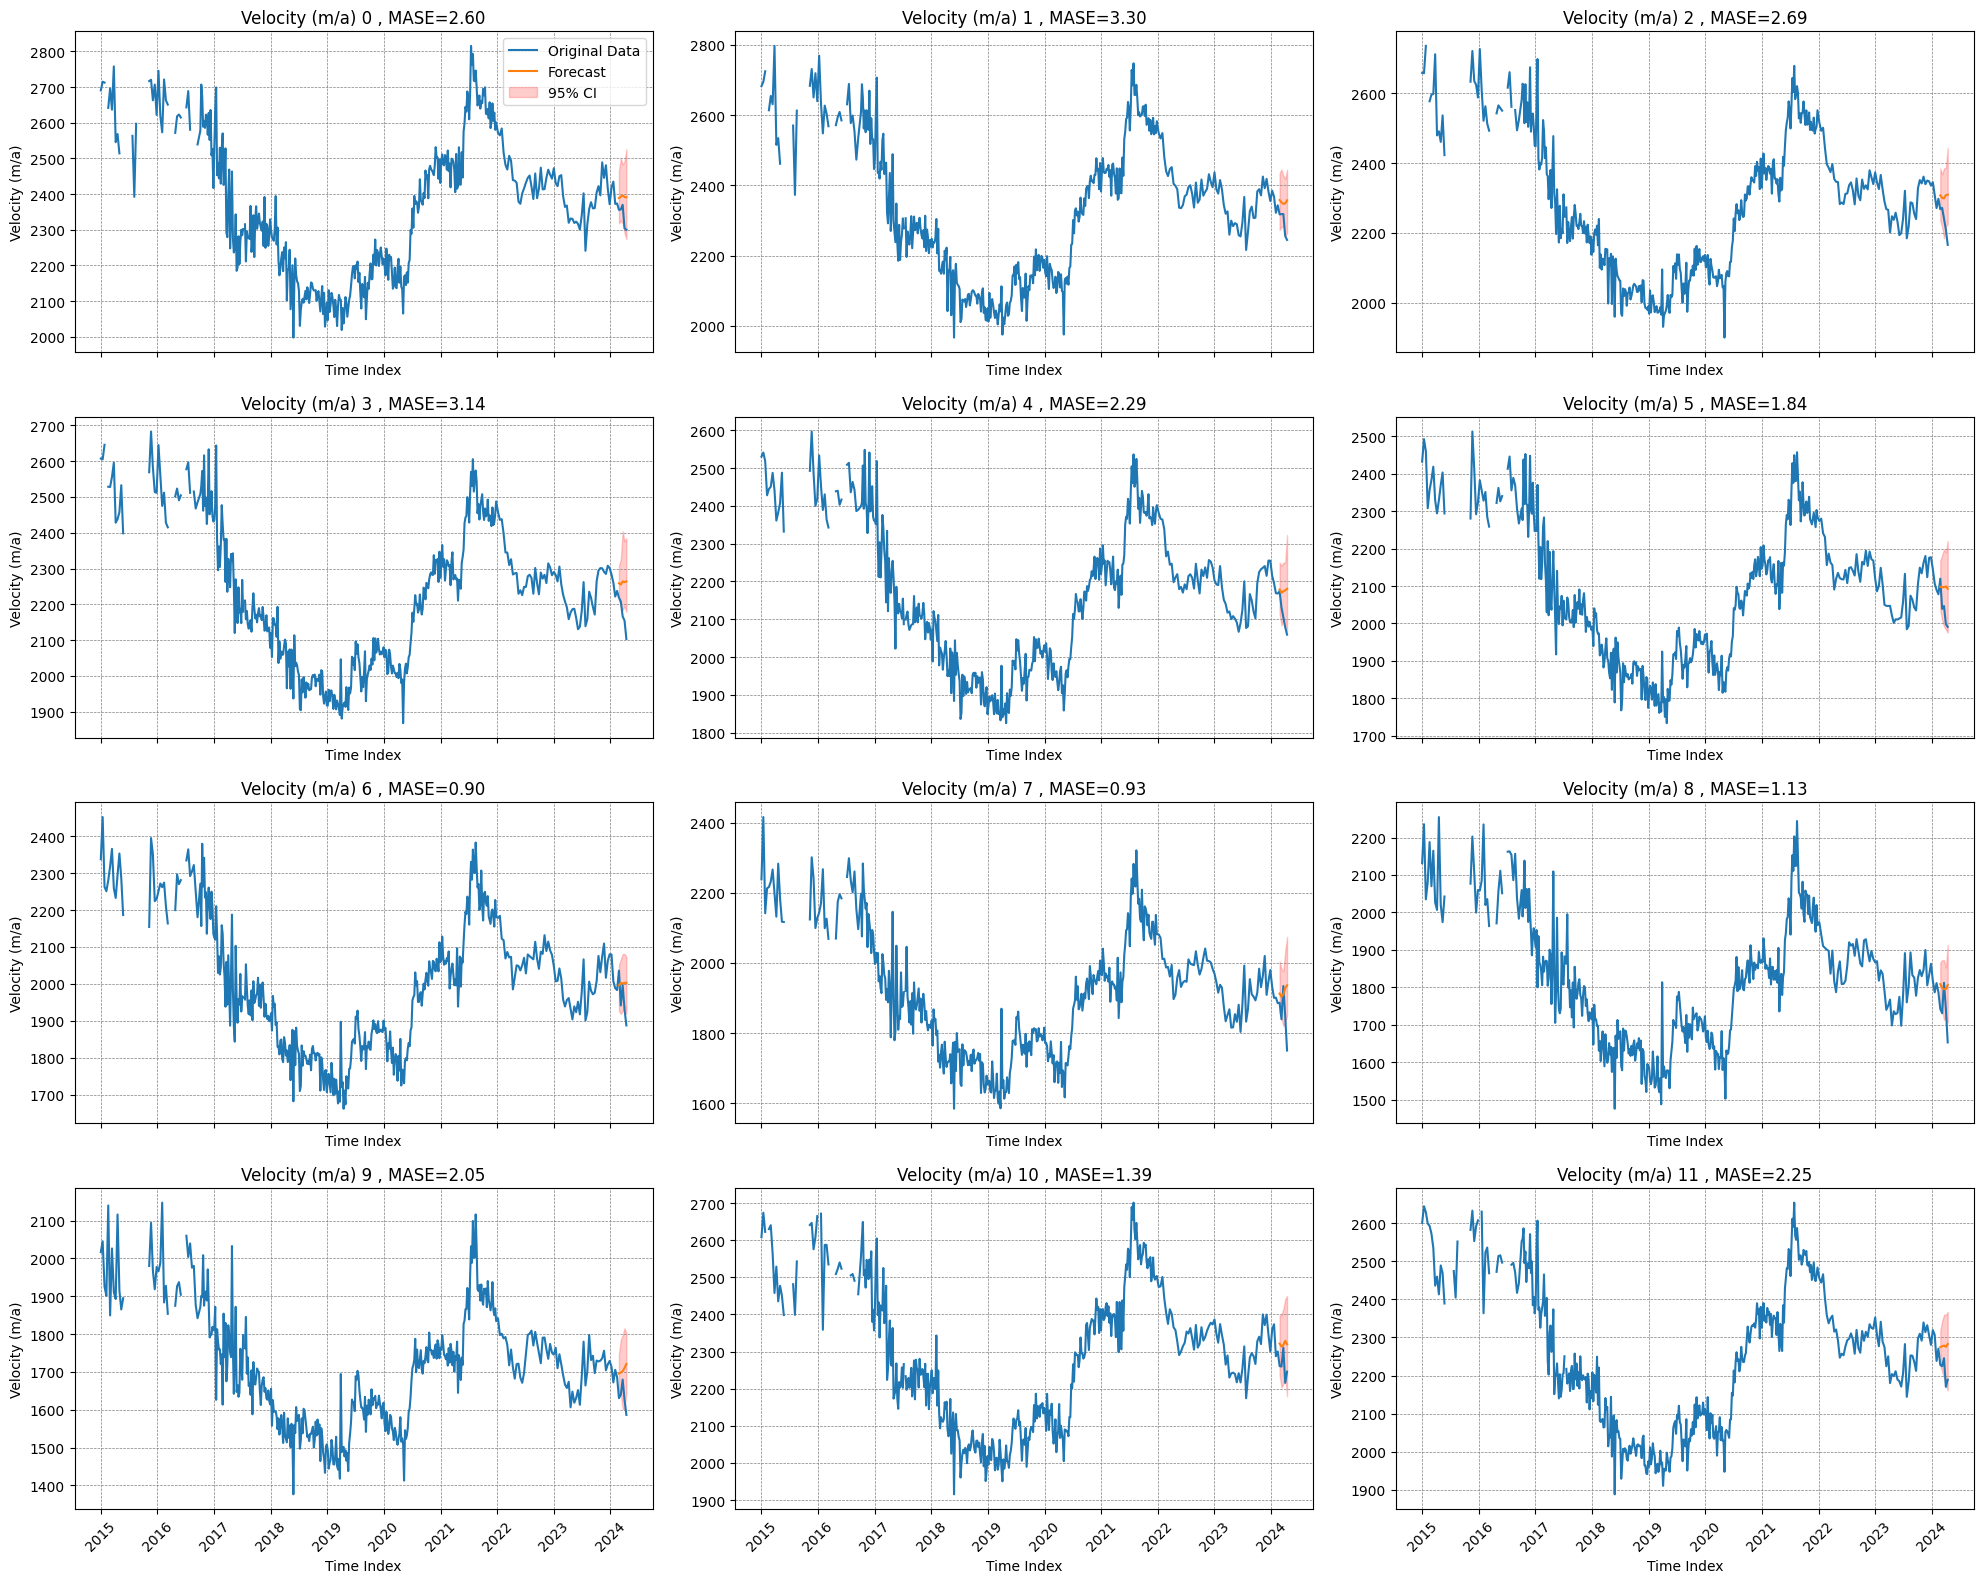

In [25]:
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,predict_length=n_predict,n_timeseries=n_timeseries)
# plot
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="Velocity (m/a)",filename="./plots/ice_jakobshavn_forecast.png")

437    2241.114204
438    2235.079933
439    2233.961544
440    2231.272566
441    2232.957779
          ...     
496    2185.462810
497    2184.613560
498    2183.764311
499    2182.915062
500    2182.065813
Name: predicted_mean, Length: 64, dtype: float64
64
Mean Absolute Scaled Error (MASE) for ARIMA: nan


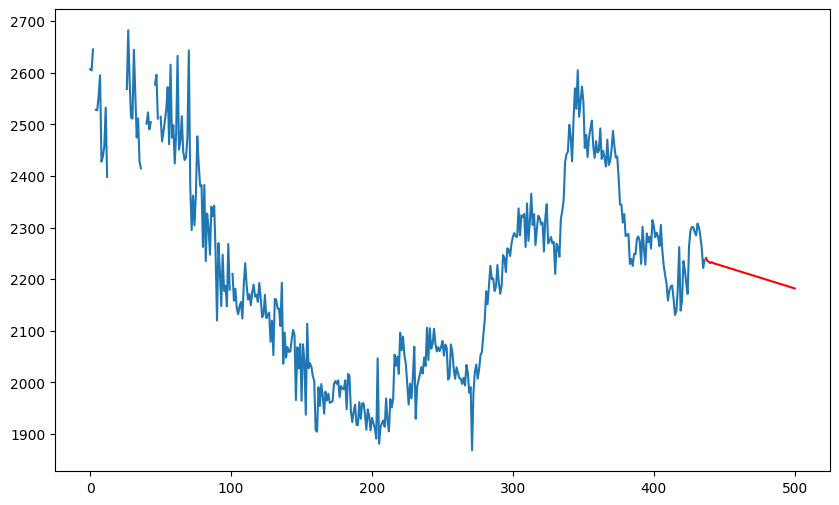

In [26]:
# benchmarking with ARIMA
# Fit ARIMA model
data = df_wide['target_3'][:split_index]
model = ARIMA(data, order=(5, 2, 1))  # (p, d, q) order, adjust as needed
model_fit = model.fit()

# Make predictions
forecast_steps = 64  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

split_index = len(df_wide['target_3'].values) - 64
print(forecast) 
# calculate the MASE between the forecast and the evaluation data
mase=[]
eval_data = df_wide['target_1'][split_index:]
print(len(df_wide['target_1'].values[split_index:]))
# Calculate and print the MASE for each time series
mase.append(np.mean(np.abs(forecast - df_wide['target_1'].values[split_index:])) / np.mean(np.abs(df_wide['target_1'].values[1:] - df_wide['target_1'].values[:-1])))
# print mase
print(f'Mean Absolute Scaled Error (MASE) for ARIMA: {mase[-1]}')

                 

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(forecast, label='Forecast', color='red')

## 3. Forecasting GPS velocities

In this case, we are going to test Chrono's performance on GPS time series. Vertical components tend to exhibit seasonal loading from precipitation, horizontal components tend to exhibit tectonic processes, especially at plate boundaries.

In [27]:
# read data from data_gps_P395_relateive_position.csv
fname = "../data/data_gps_P395_relative_position.csv"
df = pd.read_csv(fname)
# convert dacimal year column to floats
df["decimal year"] = df["decimal year"].astype(float)
df.head()

# the date format is in decimal years, convert it to datetime
# df["datetime"] = pd.to_datetime(df["decimal year"], format="%Y.%j")
# df.head()


# perform a running mean average to smooth the data
for ikey in df.keys()[1:]:
    df[ikey]=df[ikey].rolling(window=20).mean()

In [28]:

sta_name = fname.split("/")[-1].split("_")[2]
print(sta_name)

P395


In [29]:
# take the first column "decimal year" and convert it to a datetime by taking the year before the comma, then multuply by 365.25 to get the days
df["datetime"] = pd.to_datetime((df["decimal year"] - 1970) * 365.25, unit='D', origin='1970-01-01')
# move the last to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

datetime  decimal year  new delta e (m)  \
0 2006-01-25 12:11:54.959999360     2006.0671              NaN   
1 2006-01-26 11:52:00.479999488     2006.0698              NaN   
2 2006-01-27 12:24:41.759998848     2006.0726              NaN   
3 2006-01-28 12:04:47.279998976     2006.0753              NaN   
4 2006-01-29 11:44:52.799999232     2006.0780              NaN   

   new delta n (m)  new delta v (m)  
0              NaN              NaN  
1              NaN              NaN  
2              NaN              NaN  
3              NaN              NaN  
4              NaN              NaN

sampling rate 1.00 days


/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/35764

Mean Absolute Error (MAE) for target_1: 0.002572530198717625
Mean Absolute Error (MAE) for target_2: 0.0038487302440201893
Mean Absolute Error (MAE) for target_3: 0.0011598168232971494
Mean Absolute Error (MAE) for target_4: 0.0019030598718913845
Mean Absolute Error (MAE) for target_5: 0.0019899458151950017
Mean Absolute Error (MAE) for target_6: 0.0016759793565226228
Mean Absolute Error (MAE) for target_7: 0.0019449828003317718
Mean Absolute Error (MAE) for target_8: 0.0009810083987670361
Mean Absolute Error (MAE) for target_9: 0.0014775290530233747
Mean Absolute Error (MAE) for target_10: 0.0009299196242902021
Mean Absolute Error (MAE) for target_11: 0.0023257645146826794
Mean Absolute Error (MAE) for target_12: 0.003692217010083985
Mean Absolute Error (MAE) for target_13: 0.001693721470577688
Mean Absolute Error (MAE) for target_14: 0.0028380958684471073
Mean Absolute Error (MAE) for target_15: 0.0018059640359554276
Mean Absolute Error (MAE) for target_16: 0.003409404618351081
Mean 

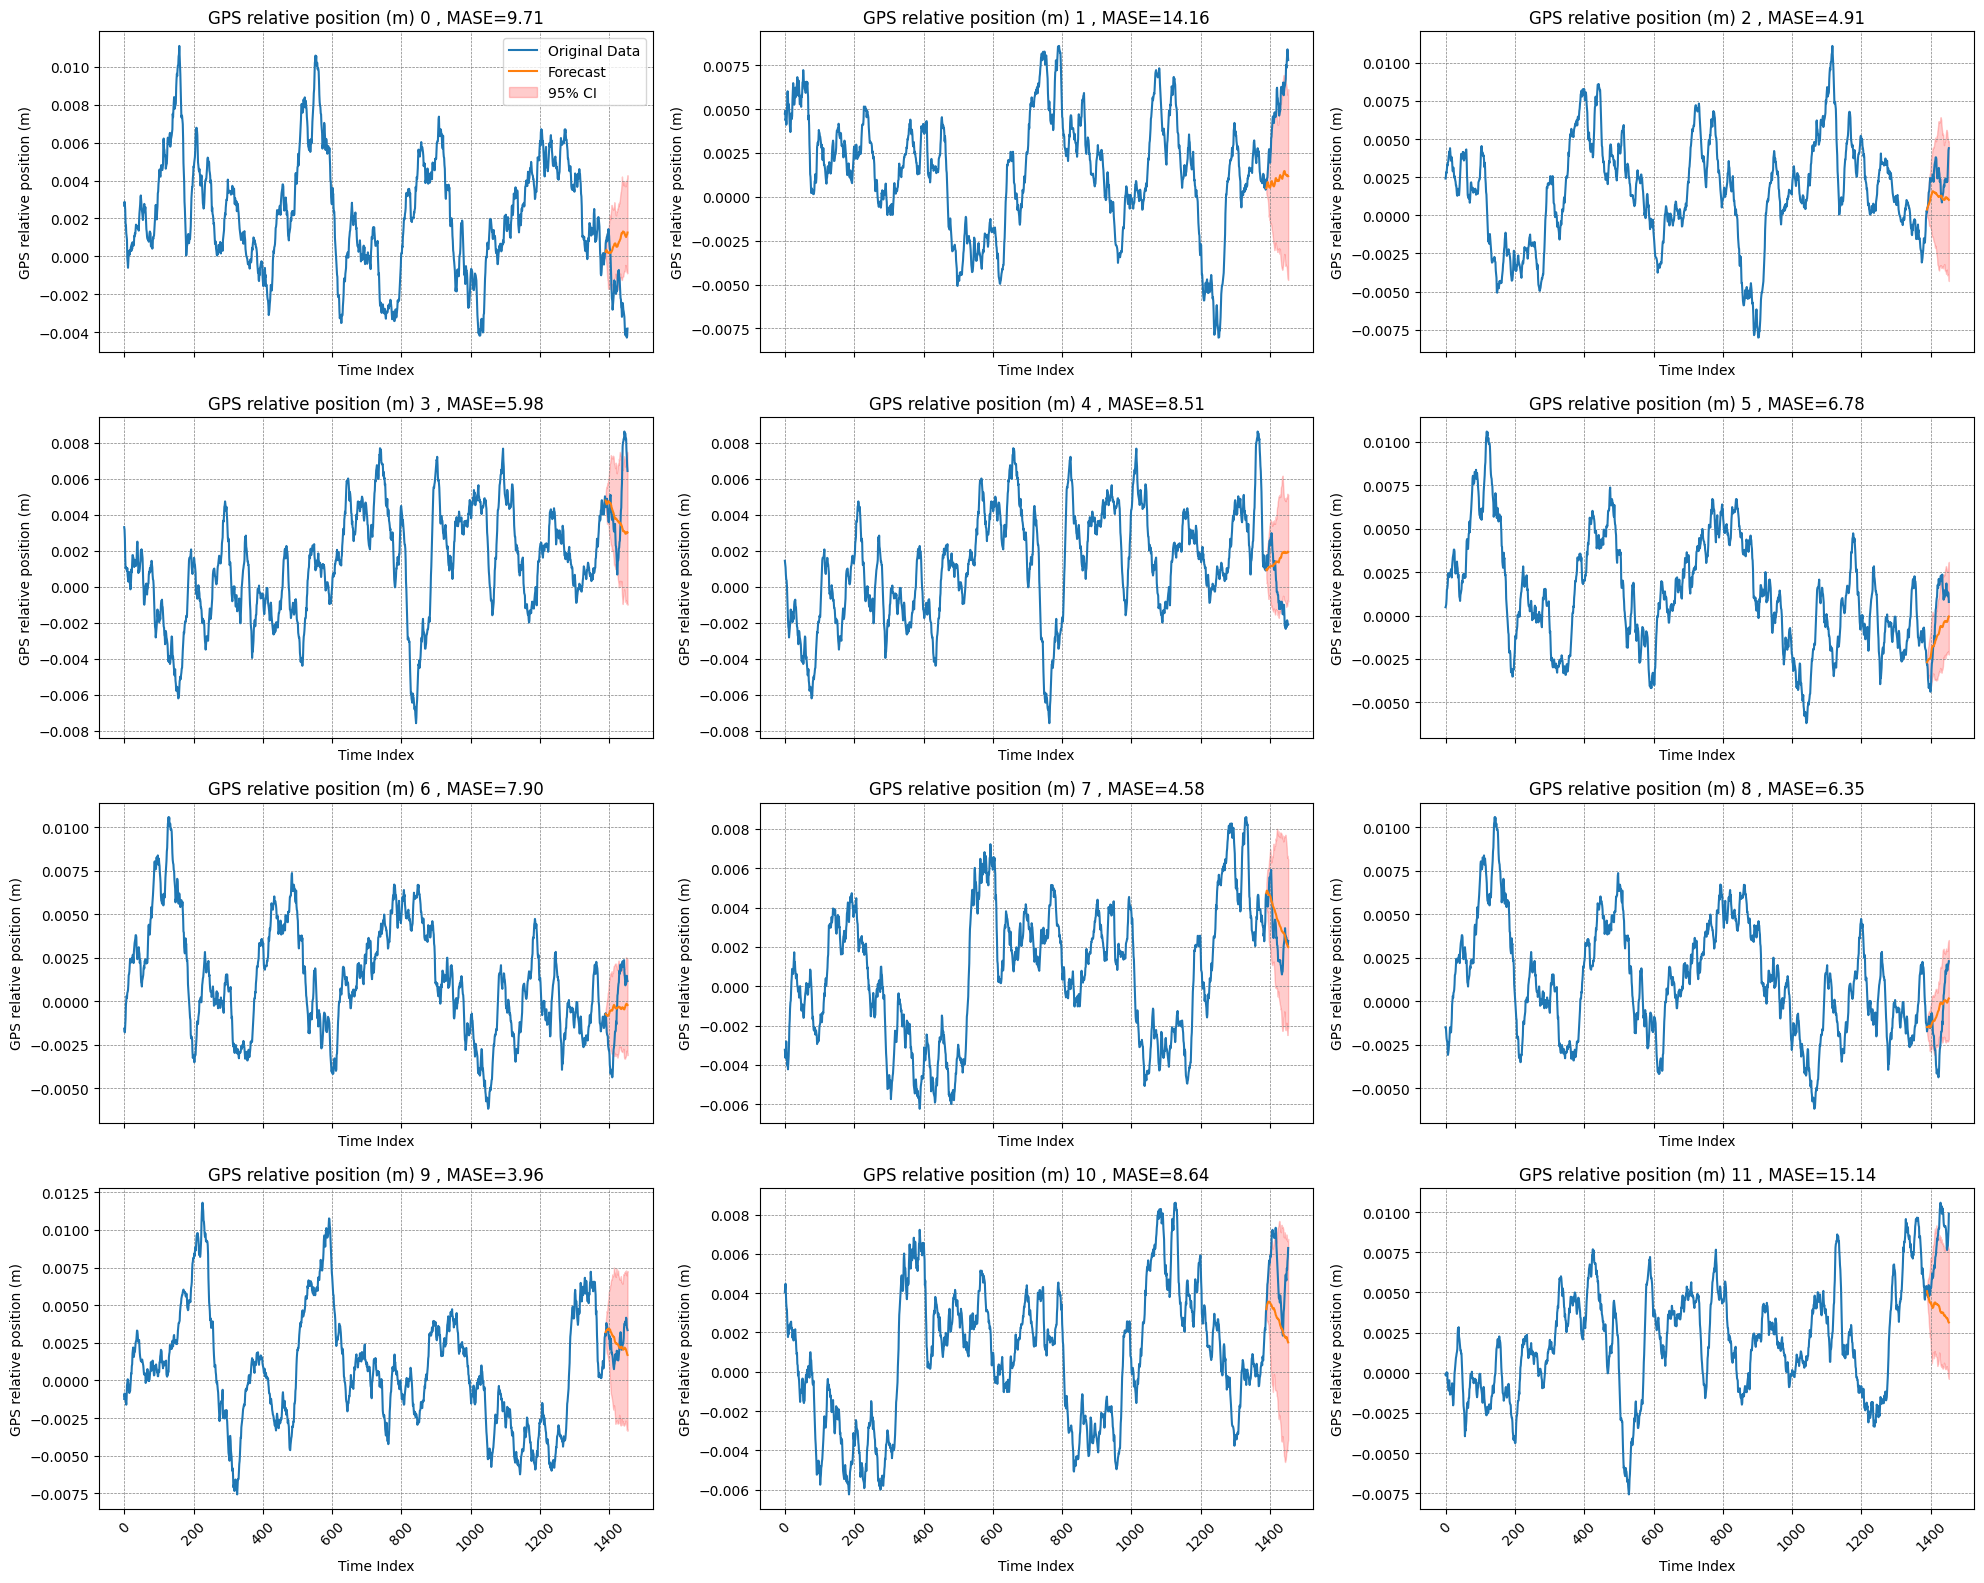

In [30]:
df_list,df_wide = reshape_time_series(df,name_of_target="new delta v (m)", n_timeseries=n_timeseries, duration_years=4)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="GPS relative position (m)",filename="./plots/gps_"+sta_name+"_v_forecast.png")


#### Horizontal components

/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/3576490523.py:21: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = start_date + pd.DateOffset(years=duration_years)
/tmp/ipykernel_3262845/35764

sampling rate 1.00 days


Mean Absolute Error (MAE) for target_1: 0.0005708975583100975
Mean Absolute Error (MAE) for target_2: 0.00051453730114518
Mean Absolute Error (MAE) for target_3: 0.0015868738067755274
Mean Absolute Error (MAE) for target_4: 0.0002645345734918849
Mean Absolute Error (MAE) for target_5: 0.00228813341587641
Mean Absolute Error (MAE) for target_6: 0.00207119634123631
Mean Absolute Error (MAE) for target_7: 0.0010431673820705044
Mean Absolute Error (MAE) for target_8: 0.0004510887342181675
Mean Absolute Error (MAE) for target_9: 0.000904343700377872
Mean Absolute Error (MAE) for target_10: 0.010745456866738539
Mean Absolute Error (MAE) for target_11: 0.000658488001693027
Mean Absolute Error (MAE) for target_12: 0.002201156237433428
Mean Absolute Error (MAE) for target_13: 0.0007853423487748522
Mean Absolute Error (MAE) for target_14: 0.0018122435863776622
Mean Absolute Error (MAE) for target_15: 0.0014540344416797157
Mean Absolute Error (MAE) for target_16: 0.0006601371092553447
Mean Absolu

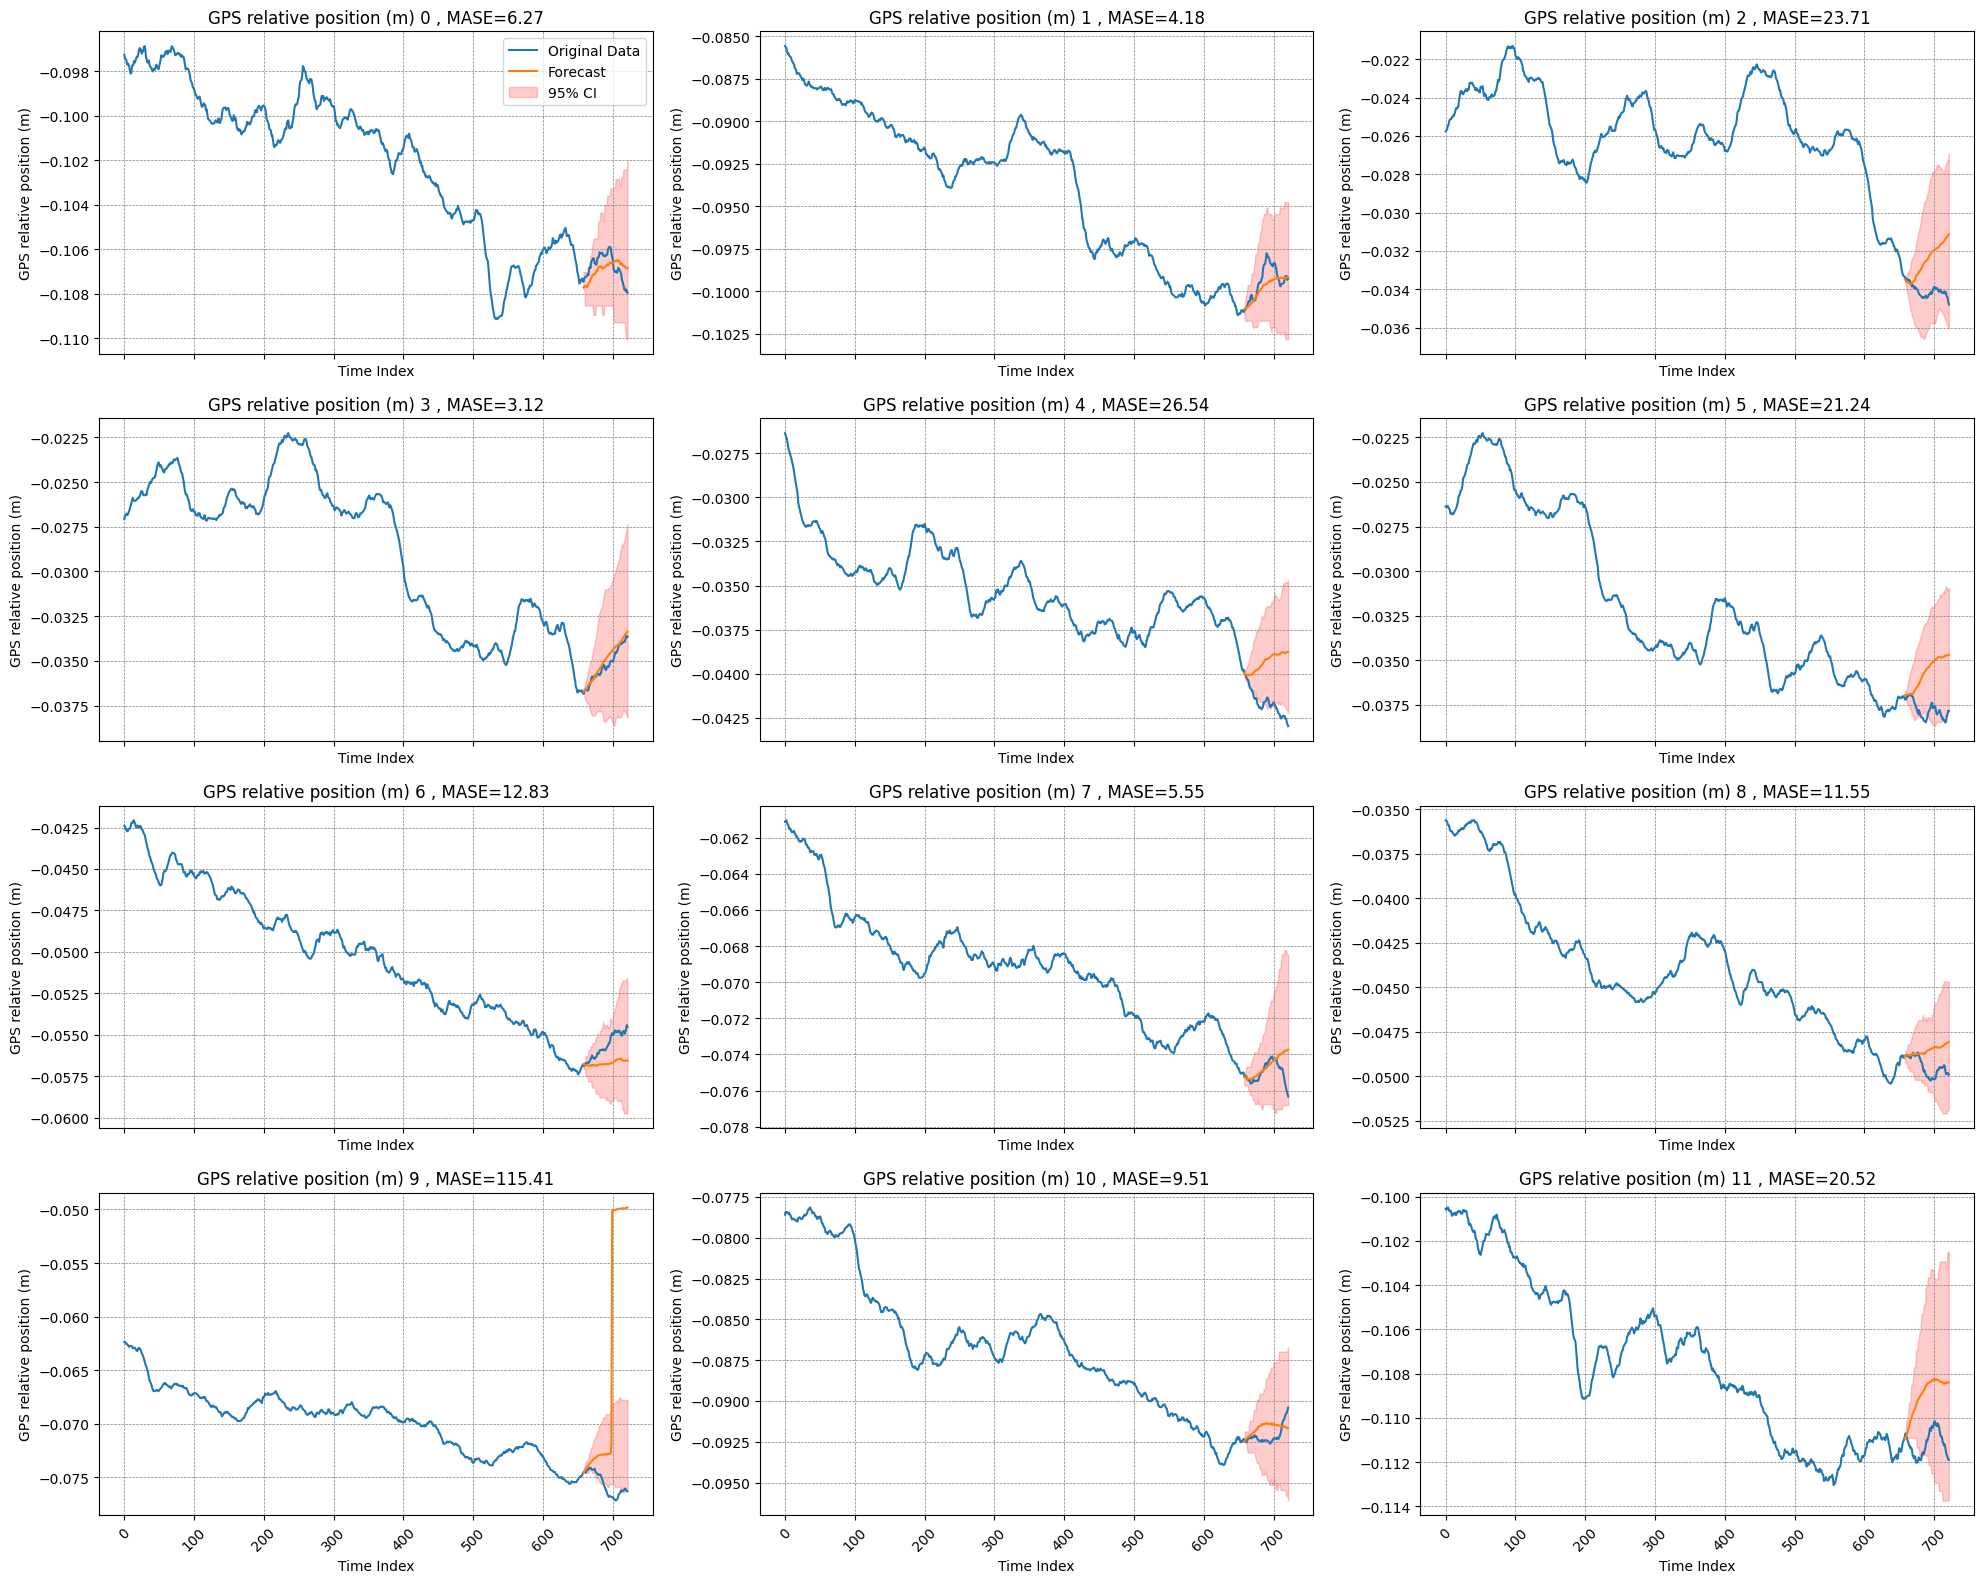

In [31]:
df_list,df_wide = reshape_time_series(df,name_of_target="new delta e (m)", n_timeseries=n_timeseries, duration_years=2)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="GPS relative position (m)",filename="./plots/gps_"+sta_name+"_e_forecast.png")


In [32]:
torch.cuda.empty_cache()
import gc
gc.collect()

41221

## 4. Forecast dv/v

In [33]:
# read one dv/v file
fname = "../data/DVV_data_withMean/Data_BGU.csv"
df = pd.read_csv(fname)
df.head()
sta_name = fname.split("/")[-1].split("_")[1]

In [34]:
# convert the date into a timestamp
df["datetime"] = pd.to_datetime(df["date"])
# move datetime to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

## Predict soil moisture

sampling rate 1.00 days


Mean Absolute Error (MAE) for target_1: 0.002538560561090709
Mean Absolute Error (MAE) for target_2: 0.02909020272120833
Mean Absolute Error (MAE) for target_3: 0.0016601330630481208
Mean Absolute Error (MAE) for target_4: 0.012607217859476803
Mean Absolute Error (MAE) for target_5: 0.004818216475099327
Mean Absolute Error (MAE) for target_6: 0.009799852903932336
Mean Absolute Error (MAE) for target_7: 0.009369094272702933
Mean Absolute Error (MAE) for target_8: 0.010449100060760975
Mean Absolute Error (MAE) for target_9: 0.0036791887901723363
Mean Absolute Error (MAE) for target_10: 0.0032064319103956252
Mean Absolute Error (MAE) for target_11: 0.0015855881713330786
Mean Absolute Error (MAE) for target_12: 0.0026623035252094267
Mean Absolute Error (MAE) for target_13: 0.006250292528420687
Mean Absolute Error (MAE) for target_14: 0.005739580380916595
Mean Absolute Error (MAE) for target_15: 0.0037804569028317926
Mean Absolute Error (MAE) for target_16: 0.01536303766593337
Mean Absolute

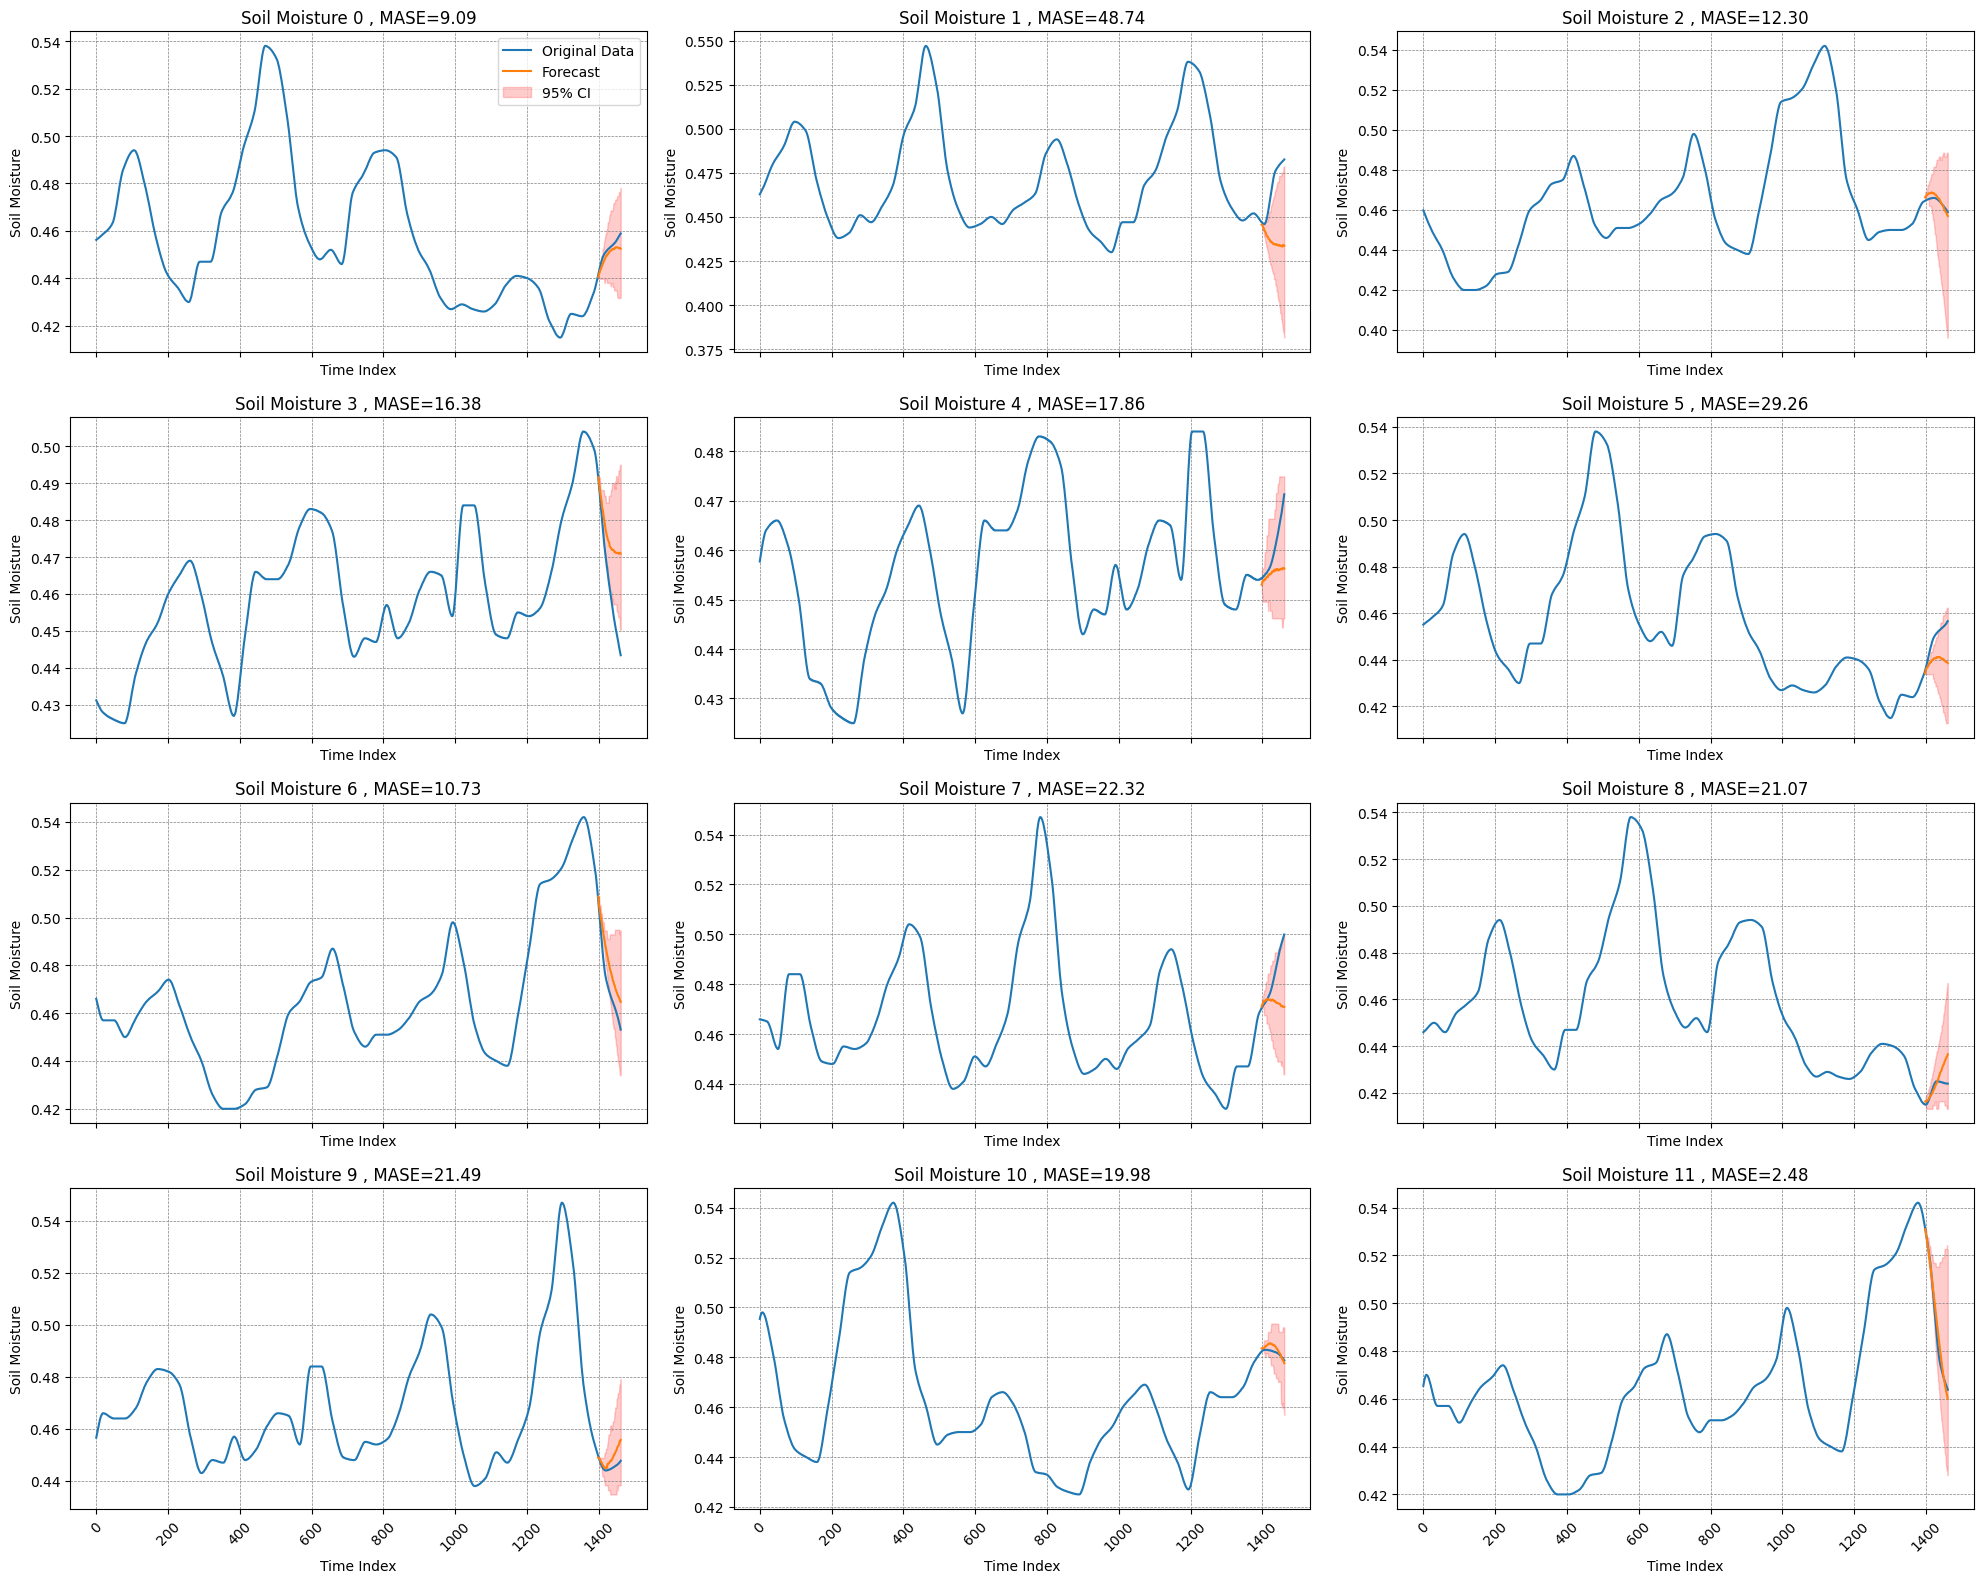

In [35]:
df_list,df_wide = reshape_time_series(df,name_of_target="sm_ewt", n_timeseries=n_timeseries, duration_years=4)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="Soil Moisture",filename="./plots/"+sta_name+"_SM_forecast.png")


In [36]:
df.keys()

Index(['datetime', 'date', 'dv', 'temp', 'sm_ewt', 'lp_lake', 'lake'], dtype='object')

sampling rate 1.00 days


Mean Absolute Error (MAE) for target_1: 0.021716991661489007
Mean Absolute Error (MAE) for target_2: 0.03364399854613949
Mean Absolute Error (MAE) for target_3: 0.009468783004395664
Mean Absolute Error (MAE) for target_4: 0.00935258114124881
Mean Absolute Error (MAE) for target_5: 0.010459179024584592
Mean Absolute Error (MAE) for target_6: 0.026136936036497353
Mean Absolute Error (MAE) for target_7: 0.021101329880114643
Mean Absolute Error (MAE) for target_8: 0.05833124969918281
Mean Absolute Error (MAE) for target_9: 0.012304479668848217
Mean Absolute Error (MAE) for target_10: 0.046390056657046076
Mean Absolute Error (MAE) for target_11: 0.035315224454214325
Mean Absolute Error (MAE) for target_12: 0.016963233578437938
Mean Absolute Error (MAE) for target_13: 0.008090451859682801
Mean Absolute Error (MAE) for target_14: 0.03904328169077635
Mean Absolute Error (MAE) for target_15: 0.026269644315727054
Mean Absolute Error (MAE) for target_16: 0.07844813361167907
Mean Absolute Error (M

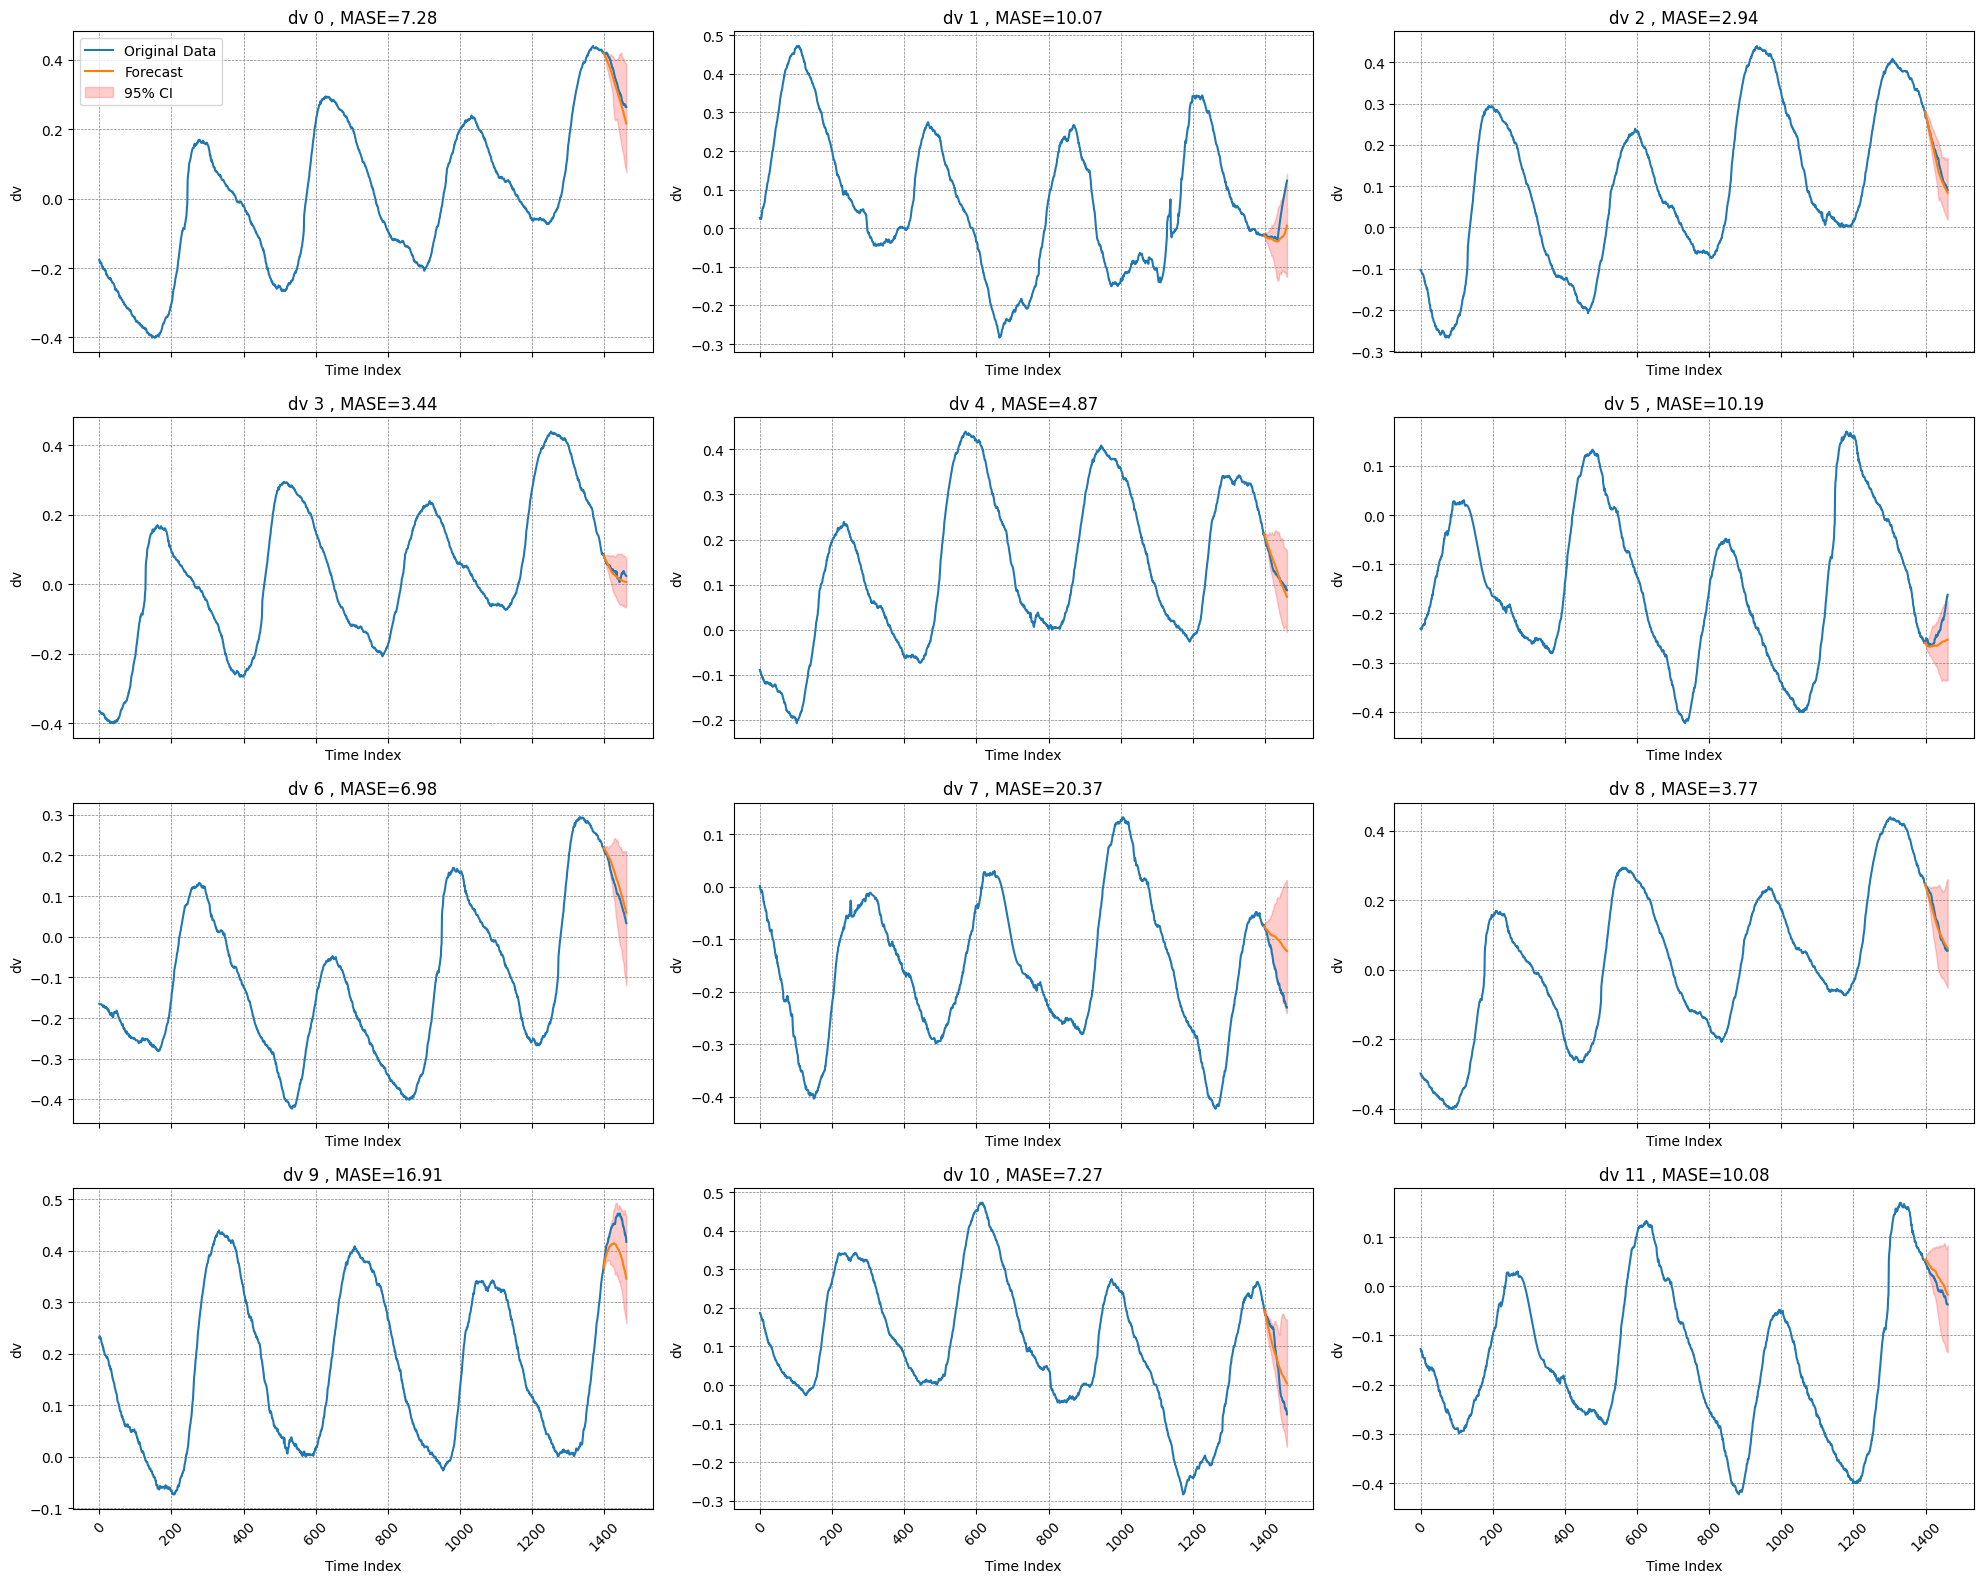

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.7801946085964213
Mean Absolute Error (MAE) for target_2: 1.9782228653192522
Mean Absolute Error (MAE) for target_3: 2.2741855033159255
Mean Absolute Error (MAE) for target_4: 0.5089310206651687
Mean Absolute Error (MAE) for target_5: 3.1070144079804427
Mean Absolute Error (MAE) for target_6: 1.5325827842116357
Mean Absolute Error (MAE) for target_7: 1.5393318197511454
Mean Absolute Error (MAE) for target_8: 2.4853420120716097
Mean Absolute Error (MAE) for target_9: 0.7282580913066864
Mean Absolute Error (MAE) for target_10: 0.48747106065377593
Mean Absolute Error (MAE) for target_11: 0.38494280869611536
Mean Absolute Error (MAE) for target_12: 1.3245760879516602
Mean Absolute Error (MAE) for target_13: 0.5807190721228719
Mean Absolute Error (MAE) for target_14: 0.46486797123402357
Mean Absolute Error (MAE) for target_15: 0.3474685760591296
Mean Absolute Error (MAE) for target_16: 0.5536221354067326
Mean Absolute Error (M

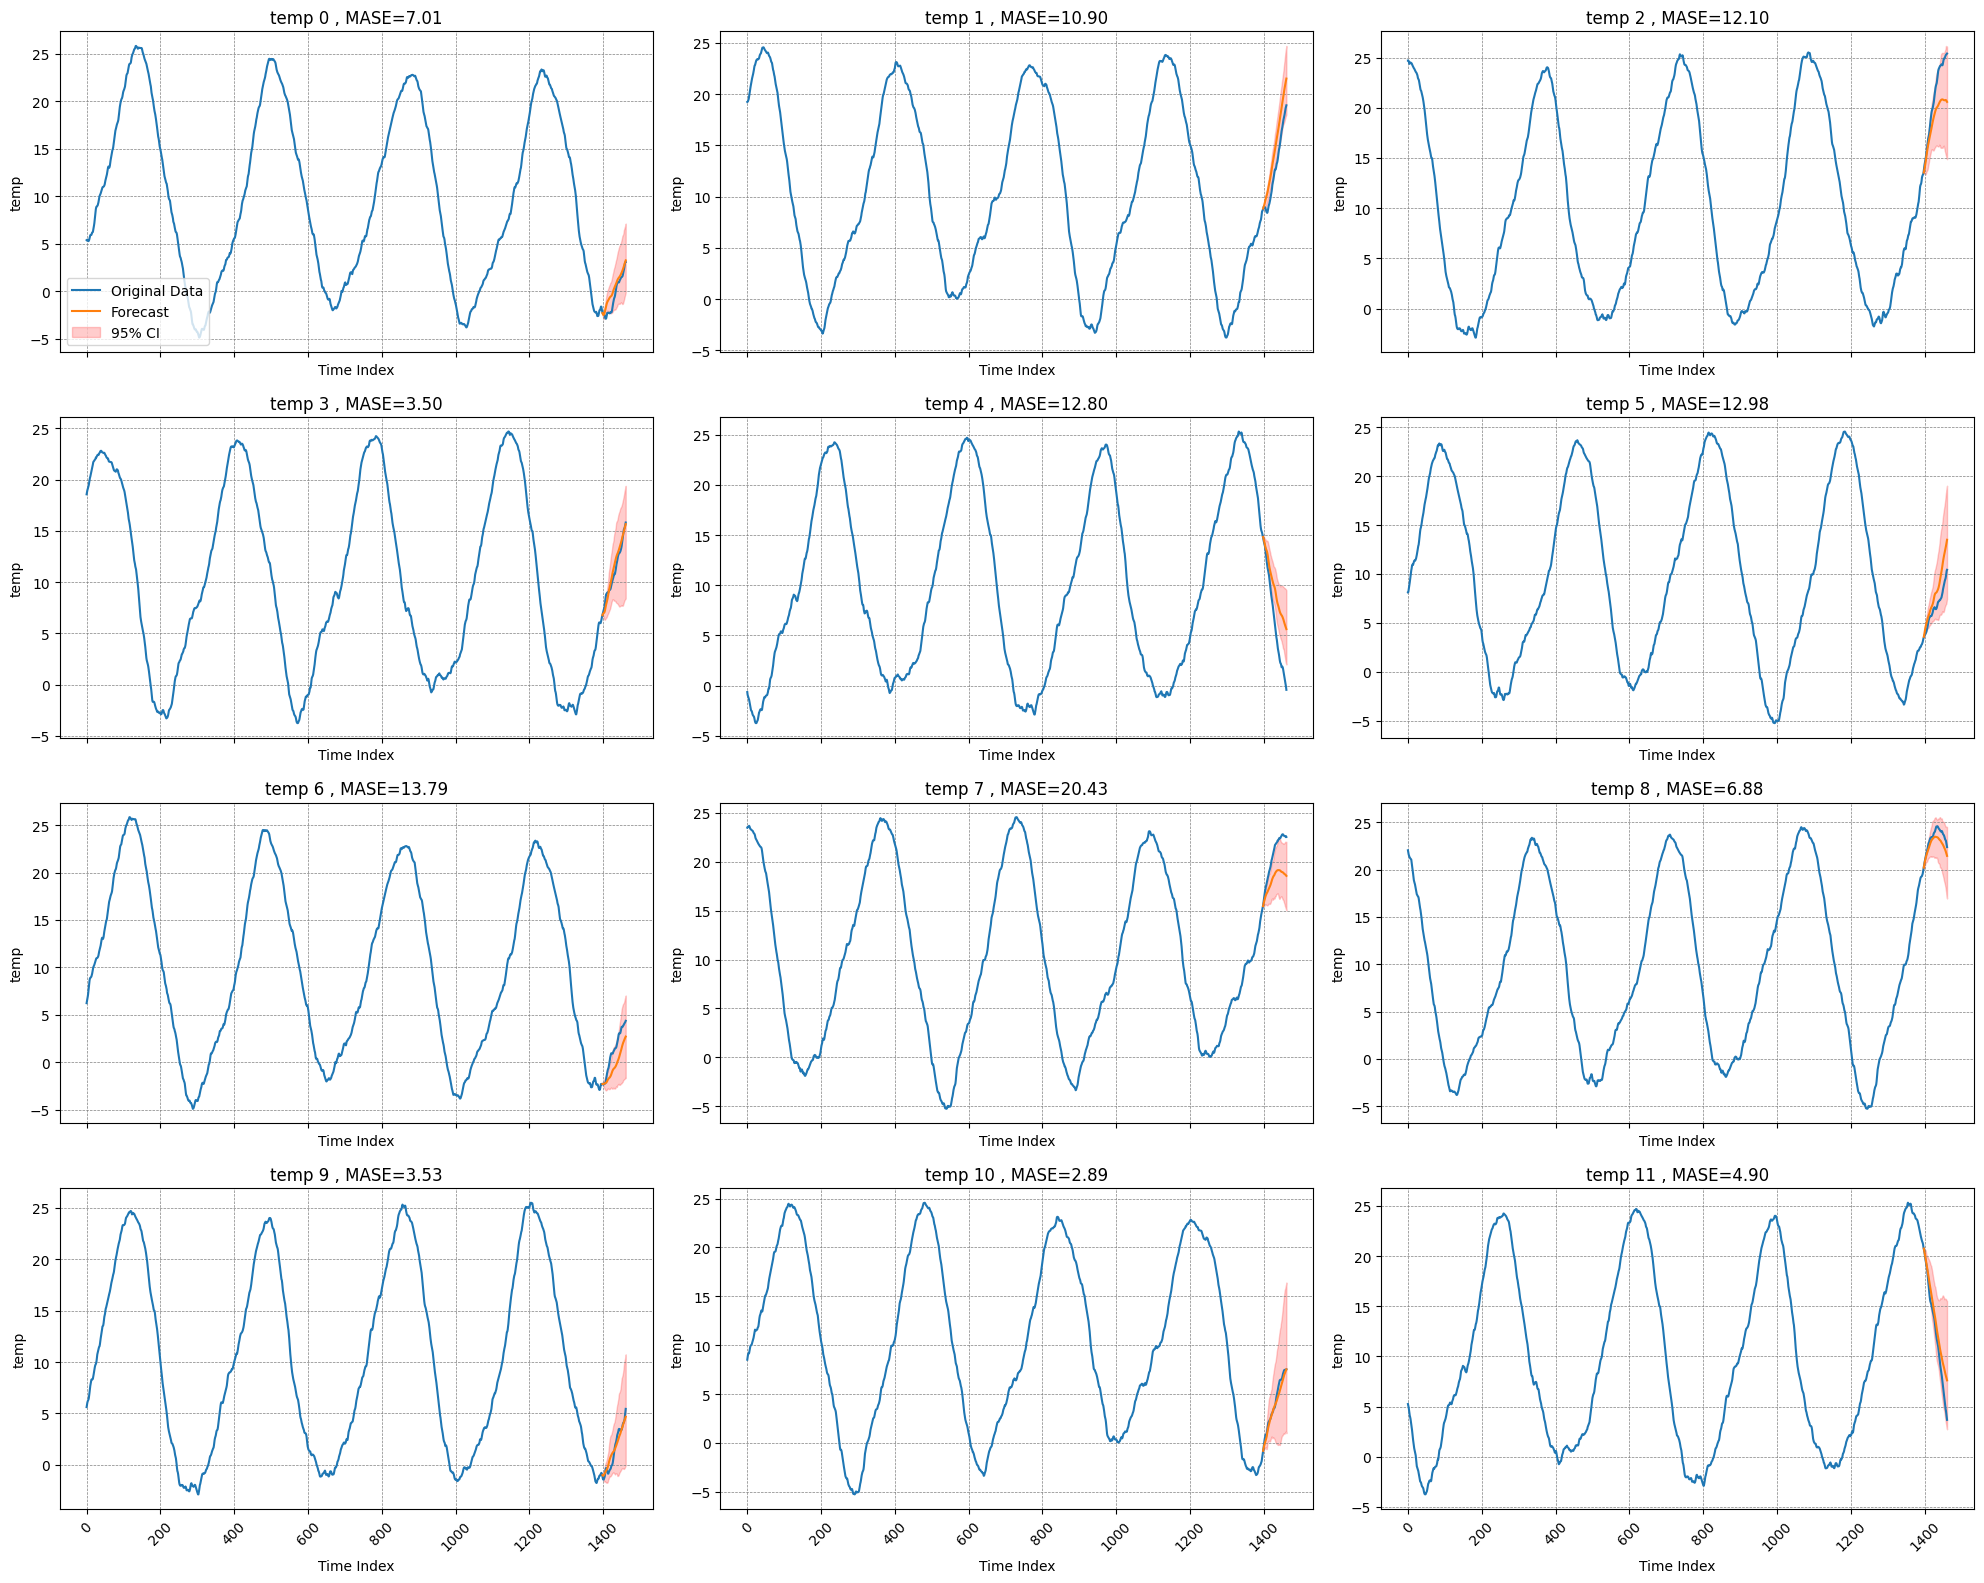

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.014285986241698264
Mean Absolute Error (MAE) for target_2: 0.0011730565689504141
Mean Absolute Error (MAE) for target_3: 0.01605626799762249
Mean Absolute Error (MAE) for target_4: 0.002911021817475554
Mean Absolute Error (MAE) for target_5: 0.007277978809177875
Mean Absolute Error (MAE) for target_6: 0.0041921036005020135
Mean Absolute Error (MAE) for target_7: 0.004550227892398836
Mean Absolute Error (MAE) for target_8: 0.015774118731915945
Mean Absolute Error (MAE) for target_9: 0.0077815586768090715
Mean Absolute Error (MAE) for target_10: 0.004076767469197513
Mean Absolute Error (MAE) for target_11: 0.021544897768646477
Mean Absolute Error (MAE) for target_12: 0.011617754981666804
Mean Absolute Error (MAE) for target_13: 0.001733267345279445
Mean Absolute Error (MAE) for target_14: 0.012577456045895816
Mean Absolute Error (MAE) for target_15: 0.0013069955475628371
Mean Absolute Error (MAE) for target_16: 0.004642396

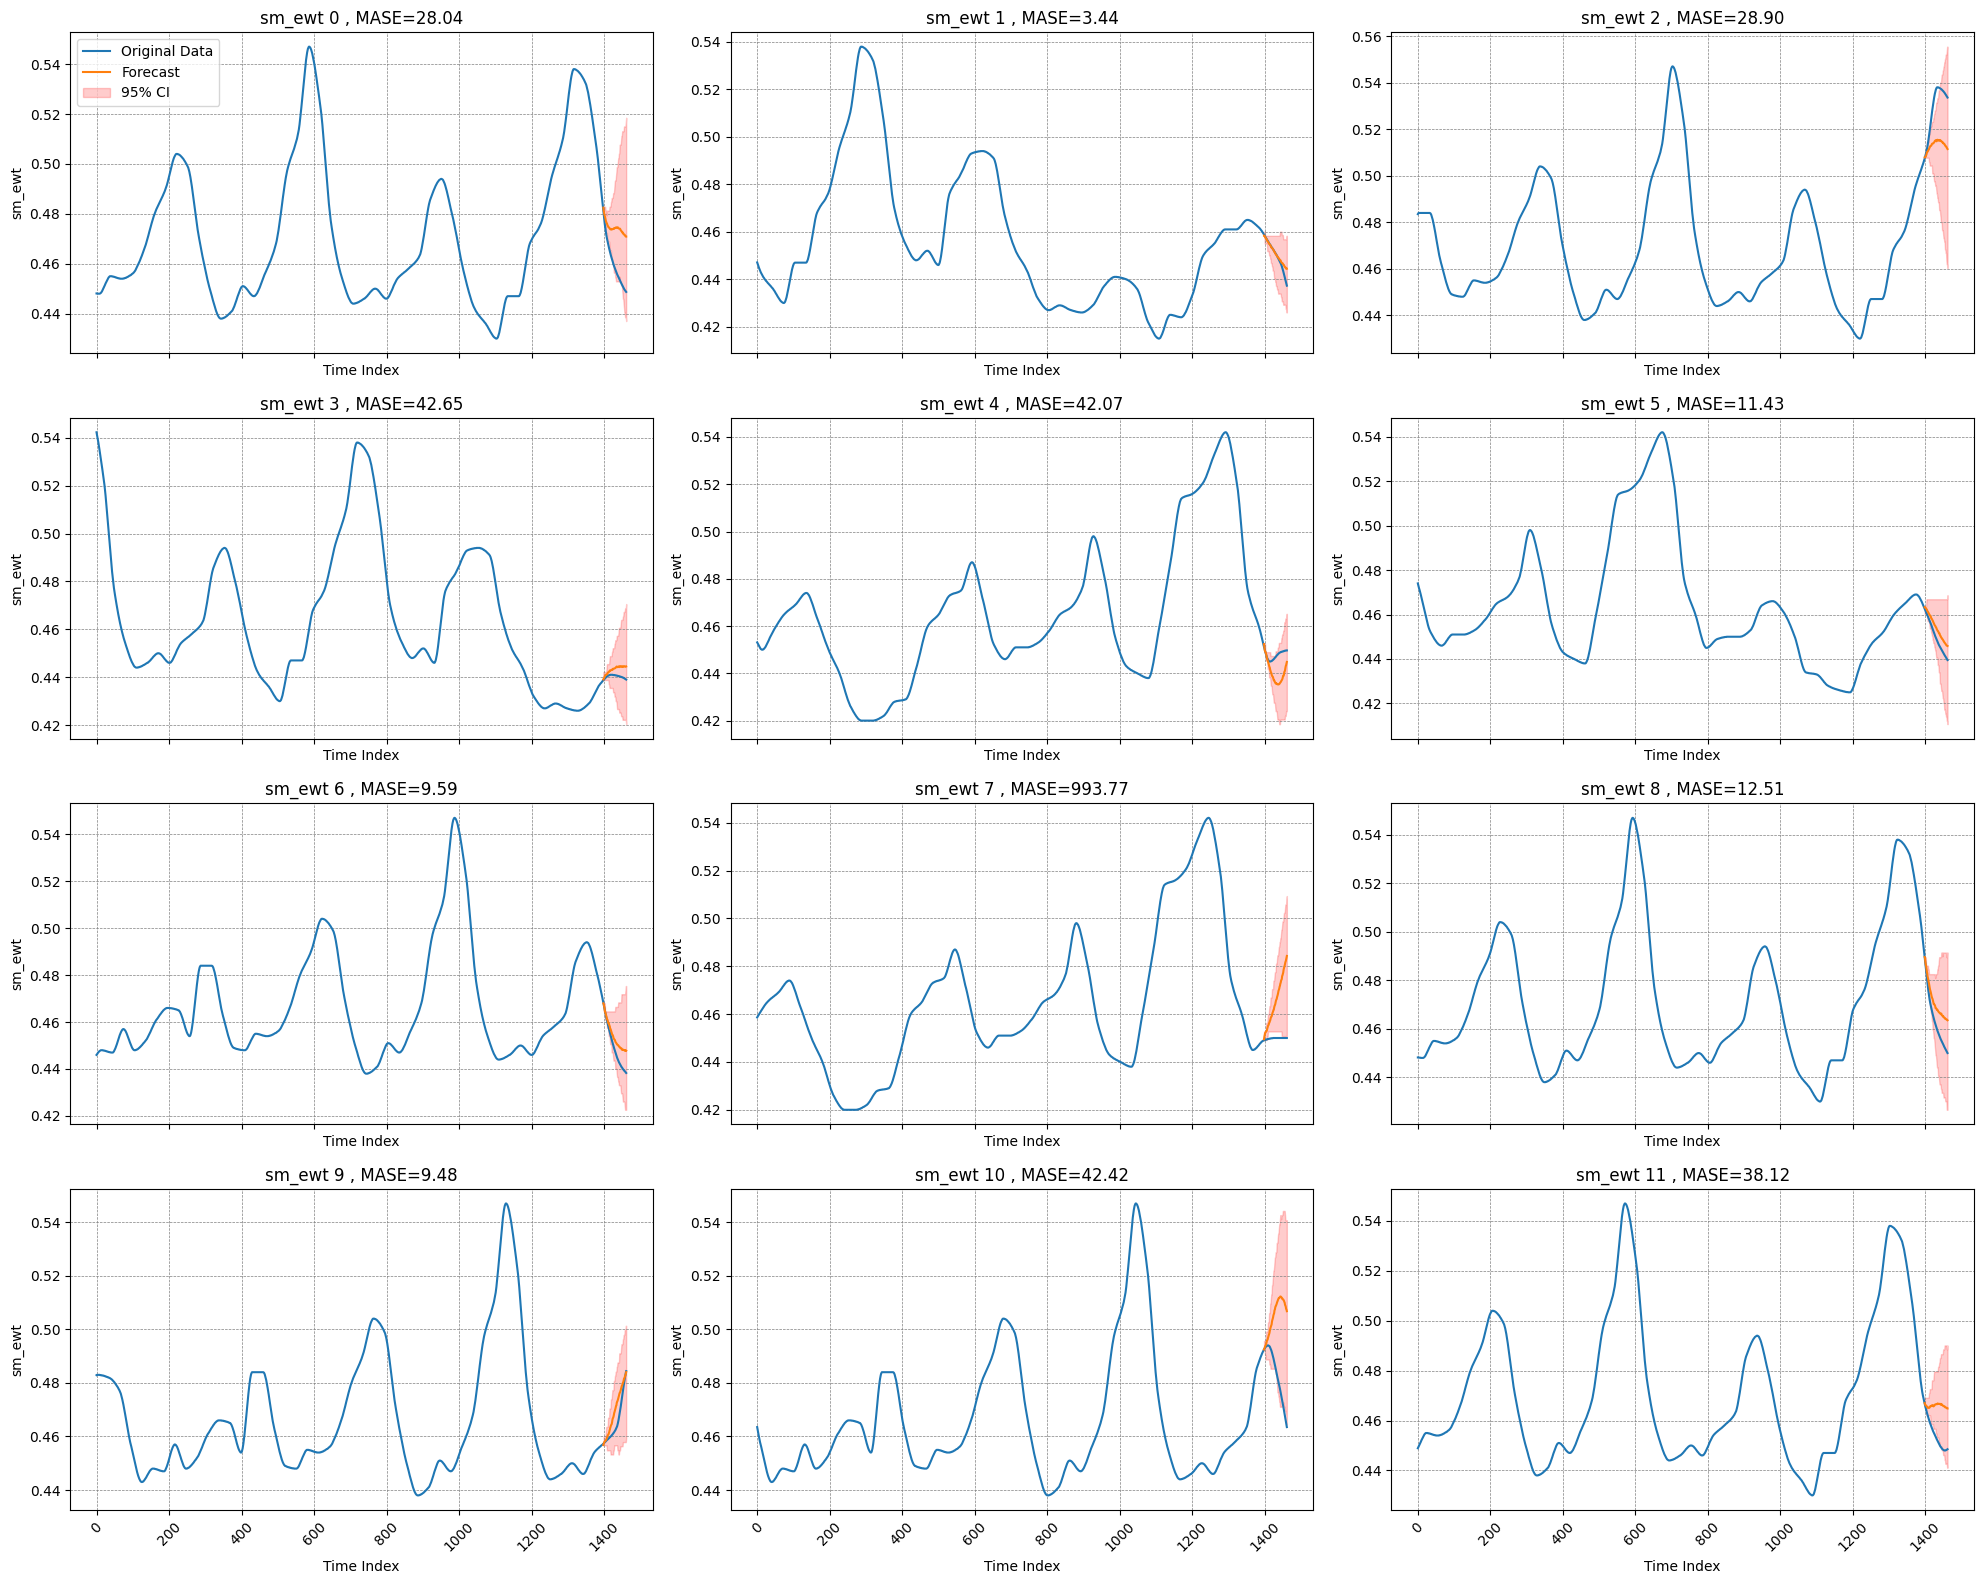

sampling rate 1.00 days
Mean Absolute Error (MAE) for target_1: 0.0013452947303652747
Mean Absolute Error (MAE) for target_2: 0.0023539248798217158
Mean Absolute Error (MAE) for target_3: 0.004296257538348437
Mean Absolute Error (MAE) for target_4: 0.0014248249150812633
Mean Absolute Error (MAE) for target_5: 0.0036793892219662647
Mean Absolute Error (MAE) for target_6: 0.008222119472455233
Mean Absolute Error (MAE) for target_7: 0.0028767300114035613
Mean Absolute Error (MAE) for target_8: 0.005613493846356872
Mean Absolute Error (MAE) for target_9: 0.0037836987569928194
Mean Absolute Error (MAE) for target_10: 0.006955197760462757
Mean Absolute Error (MAE) for target_11: 0.0009536257168278108
Mean Absolute Error (MAE) for target_12: 0.0015637497514486304
Mean Absolute Error (MAE) for target_13: 0.003998038429021838
Mean Absolute Error (MAE) for target_14: 0.0013880359843373288
Mean Absolute Error (MAE) for target_15: 0.004119994397833944
Mean Absolute Error (MAE) for target_16: 0.010

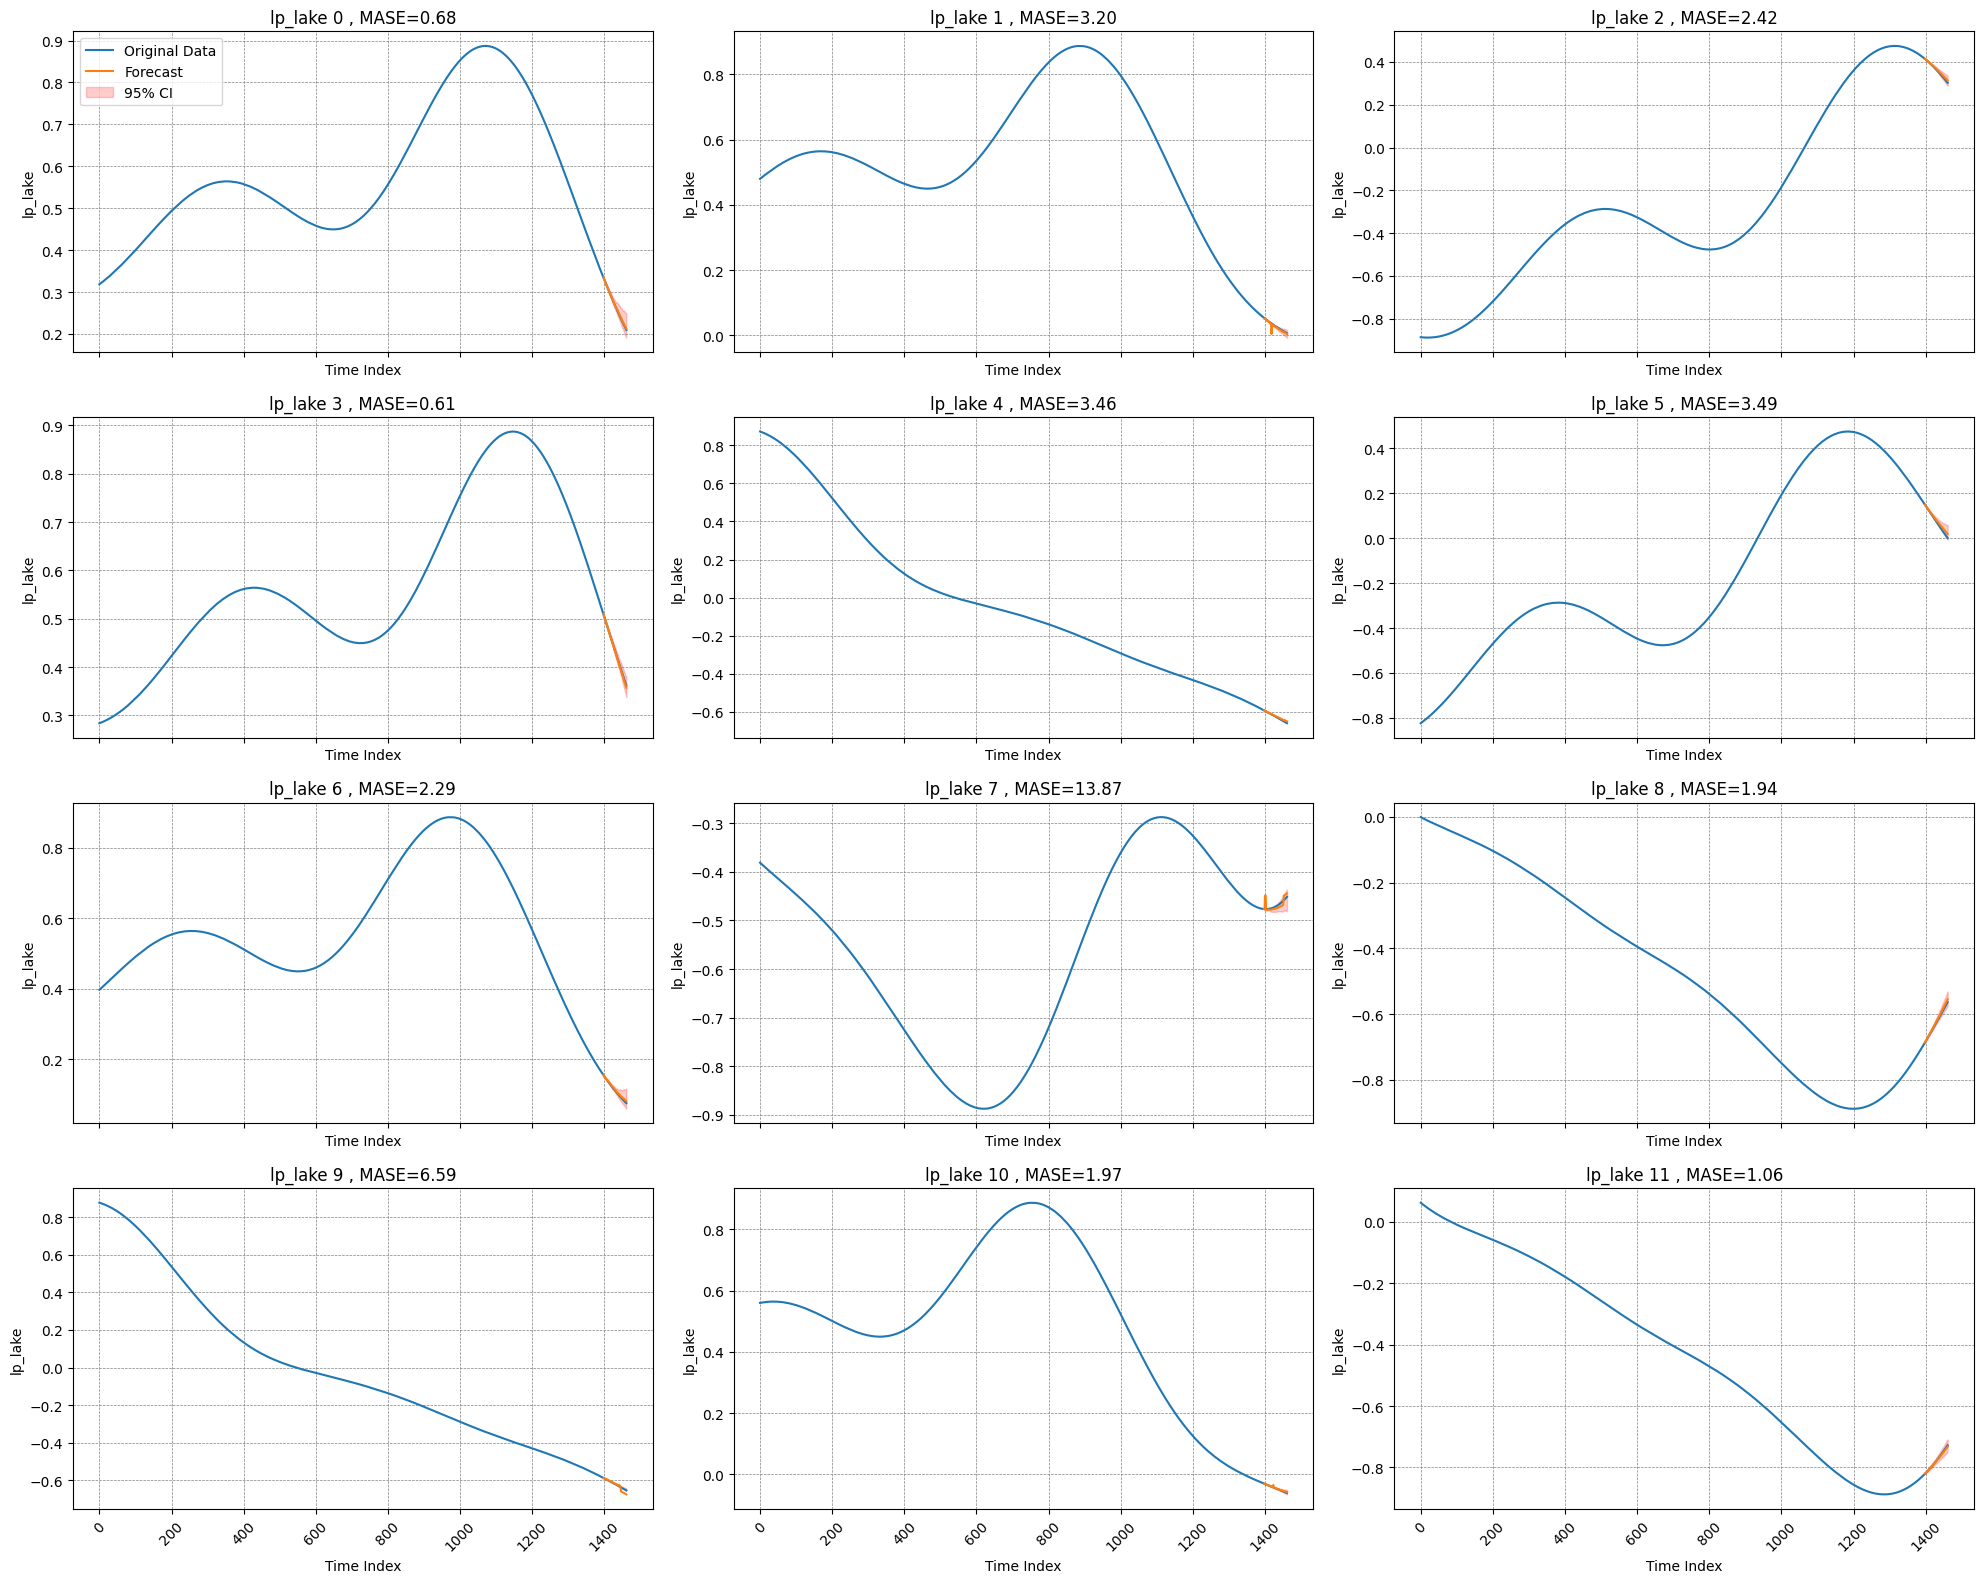

sampling rate 1.00 days


KeyboardInterrupt: 

In [37]:
for ikey in df.keys()[2:]:
    if ikey == "lake":
        # remove mean of the column
        df[ikey] = df[ikey] - df[ikey].mean()
    df_list,df_wide = reshape_time_series(df,name_of_target=ikey, n_timeseries=n_timeseries, duration_years=4)
    # now predict with chronos
    forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
    # plot the forecast
    plot_forecasts(df_wide,split_index,forecast,n_timeseries,field=ikey,filename="./plots/"+sta_name+"_"+ikey+"_forecast.png")

In [34]:
torch.cuda.empty_cache()
import gc
gc.collect()

79442

## Wave data

In [62]:
# read CSV file with waveforms in them
df = pd.read_csv("../data/data_waveforms.csv")
df.head()

time             Z             N             E
0   0.0  20525.021459 -19224.056196 -47203.488344
1   0.2  -7242.363758   4543.589720  14463.495052
2   0.4  -1562.630597   5935.755557  -9257.204055
3   0.6   -907.924879  -4912.978439   3321.988412
4   0.8   -432.534303   1306.775470  -9014.431029

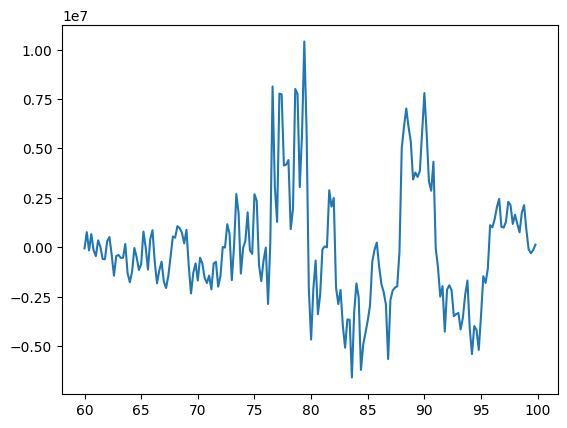

In [63]:


# trim data between 100 and 200 rows
df = df.iloc[300:500]
plt.plot(df['time'],df['Z'])

In [64]:
#make a datetime column
df["datetime"] = pd.to_datetime(df["time"], unit='s')

In [65]:
df.head()

time              Z             N             E                datetime
300  60.0  -57606.629529 -2.573779e+05  6.197990e+05 1970-01-01 00:01:00.000
301  60.2  759129.457313 -1.648418e+06  6.218192e+05 1970-01-01 00:01:00.200
302  60.4 -162872.299689 -1.265414e+06  1.165485e+06 1970-01-01 00:01:00.400
303  60.6  661913.744192 -9.992476e+05  1.967648e+05 1970-01-01 00:01:00.600
304  60.8 -157058.566878 -2.788764e+06  2.463665e+05 1970-01-01 00:01:00.800

In [70]:
df_wide.head()

target_0      target_1      target_2  time_index  forecast_0  \
0  -57606.629529 -2.573779e+05  6.197990e+05           0         NaN   
1  759129.457313 -1.648418e+06  6.218192e+05           1         NaN   
2 -162872.299689 -1.265414e+06  1.165485e+06           2         NaN   
3  661913.744192 -9.992476e+05  1.967648e+05           3         NaN   
4 -157058.566878 -2.788764e+06  2.463665e+05           4         NaN   

   forecast_1  forecast_2  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

Mean Absolute Error (MAE) for target_0: 2880409.8643965963
Mean Absolute Error (MAE) for target_1: 3513737.344627455
Mean Absolute Error (MAE) for target_2: 2741876.403510586
Mean of forecast MAEs = 3045341.204178212
Mean Absolute Scaled Error (MASE) for target_0: 2.771949667494656
Mean Absolute Scaled Error (MASE) for target_1: 2.734191693181469
Mean Absolute Scaled Error (MASE) for target_2: 3.4496832352871962
Mean of forecast MAEs = 2.985274865321107
Mean of d/dt=0 MAEs = 3511698.7101742276
Mean of forecast MASEs = 2.985274865321107


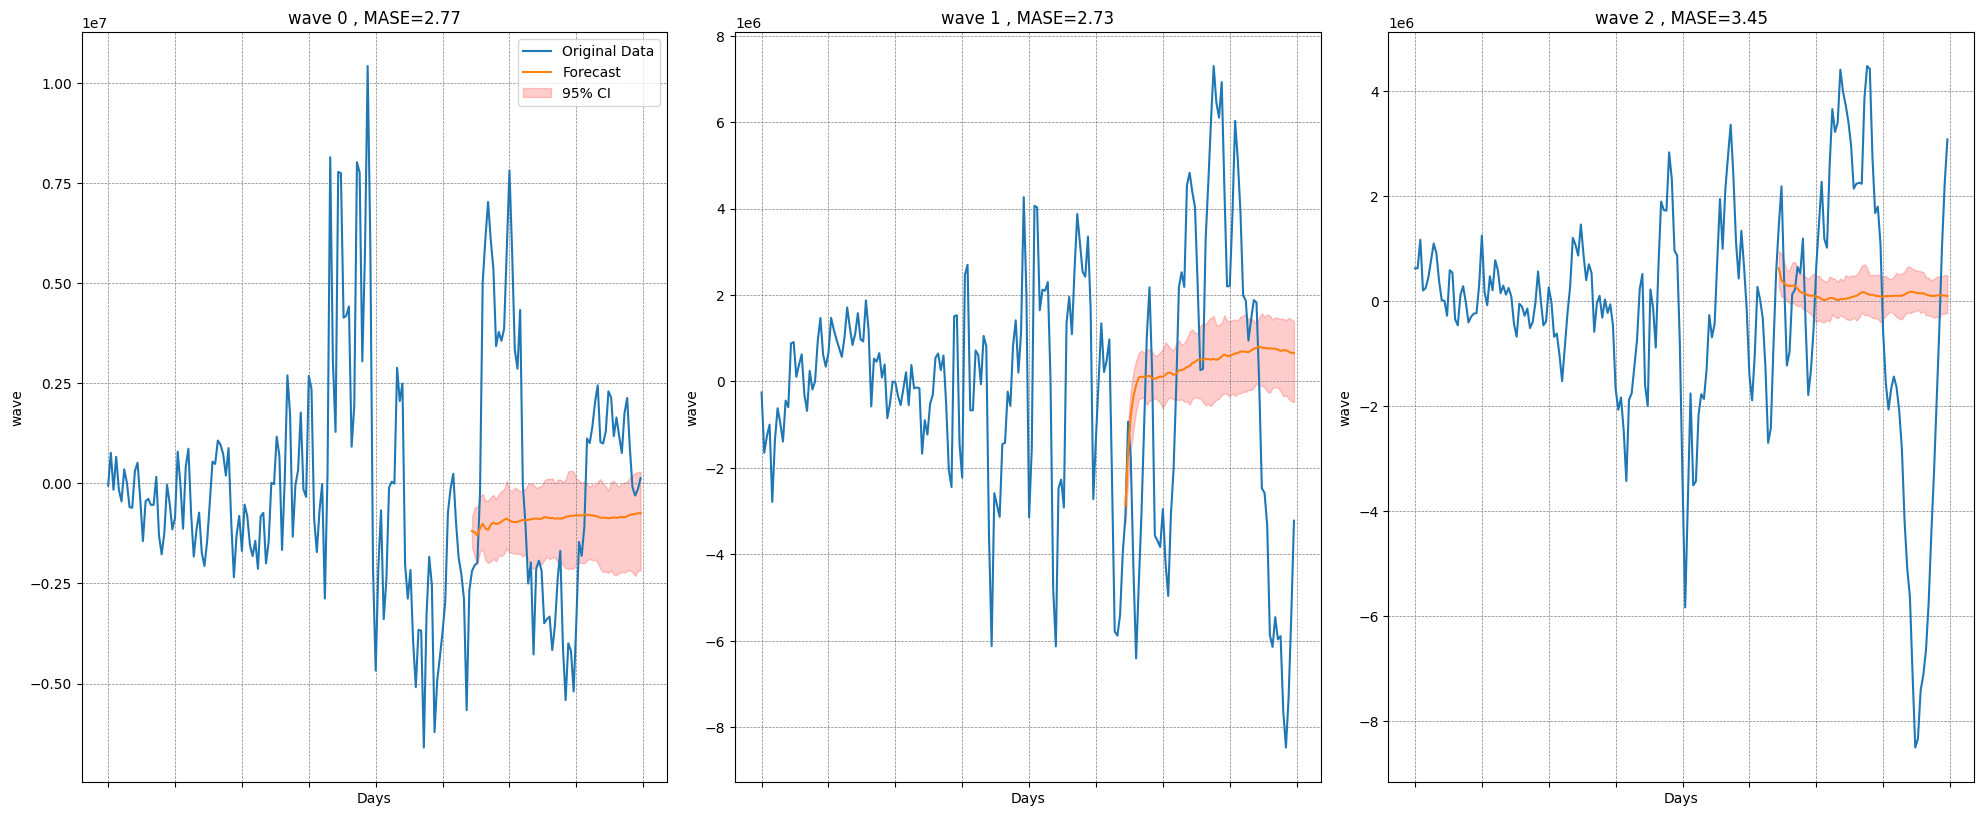

In [71]:
df_wide = df
# rename the keys from Z, N, E, to target_0, target_1, target_2
df_wide.columns = ["time","target_0","target_1","target_2","datetime"]

# reset df_wide index:
df_wide = df_wide.reset_index(drop=True)

# create a time_index column that is the index of the time series
df_wide["time_index"] = np.arange(len(df_wide))

# move datetime to the first position
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]

# drop columns time and datetime
df_wide = df_wide.drop(columns=["time","datetime"])

# # now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,predict_length=64, n_timeseries=len(df.keys())-1)
# # plot the forecast
plot_forecasts(df_wide,split_index,forecast,len(df.keys())-1,field="wave",filename="./plots/waveforms_forecast.png")

Mean Absolute Error (MAE) for target_0: 0.9705108349004272
Mean Absolute Error (MAE) for target_1: 1.2307382948076773
Mean Absolute Error (MAE) for target_2: 1.2139097073320535
Mean Absolute Error (MAE) for forecast_0: 0.7246984243392944
Mean of forecast MAEs = 1.034964315344863
Mean Absolute Scaled Error (MASE) for target_0: 2.771656532253859
Mean Absolute Scaled Error (MASE) for target_1: 2.7693646199812054
Mean Absolute Scaled Error (MASE) for target_2: 3.432071373969857
Mean Absolute Scaled Error (MASE) for forecast_0: 3.2199456691741943
Mean of forecast MAEs = 3.048259548844779
Mean of d/dt=0 MAEs = 1.324130748546469
Mean of forecast MASEs = 3.048259548844779


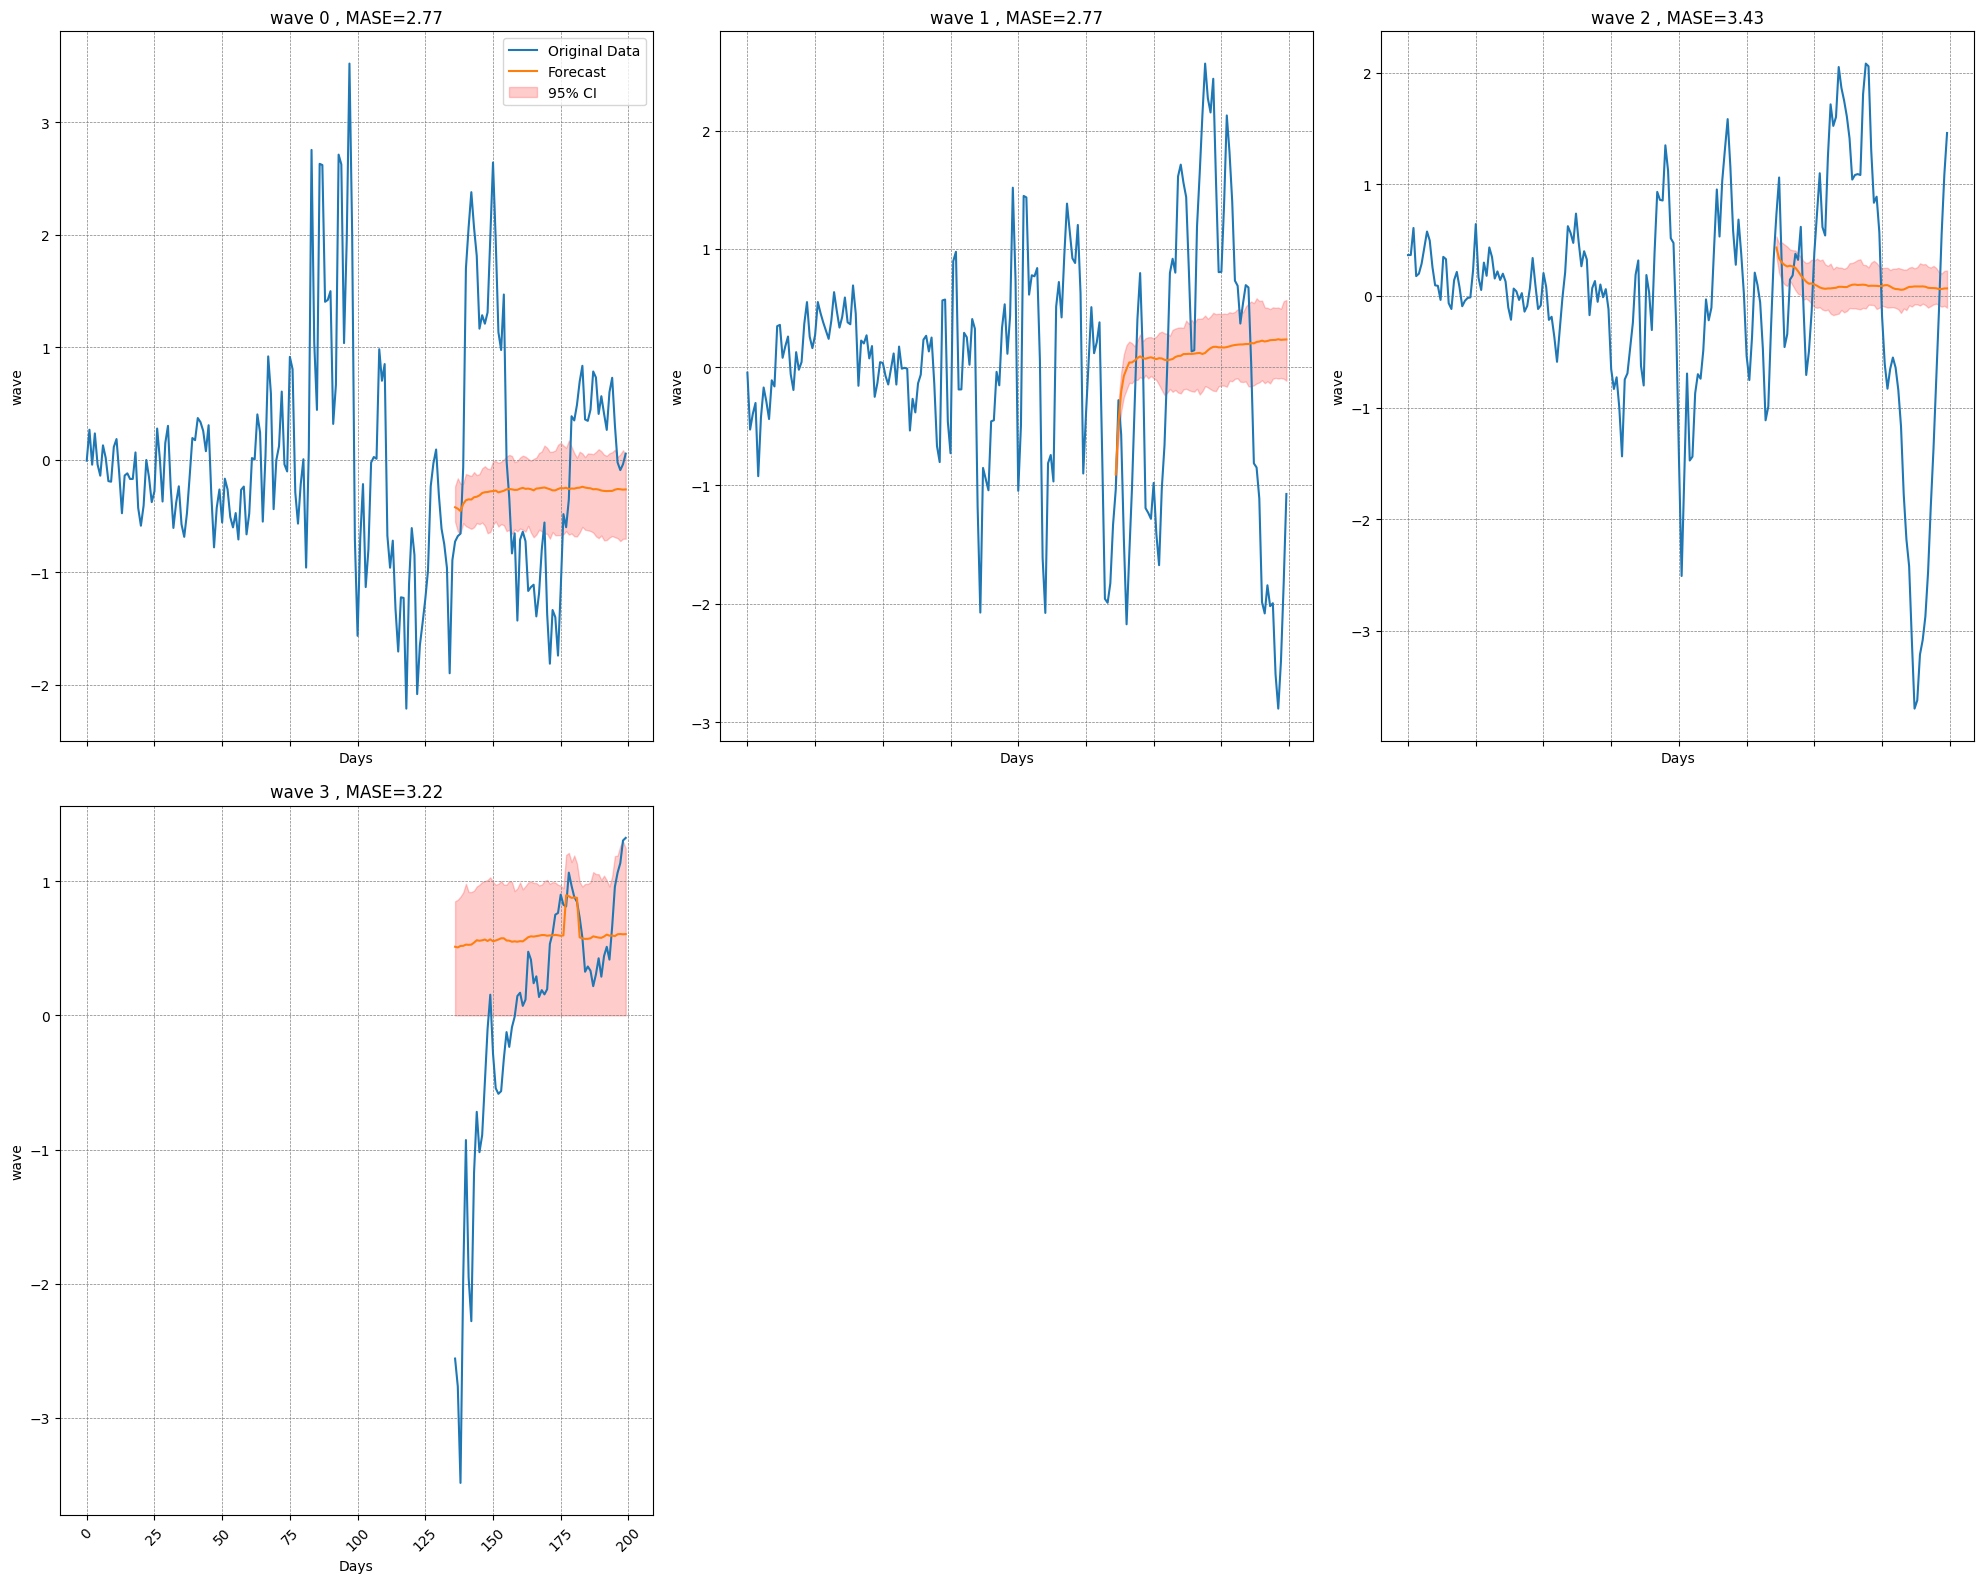

In [73]:
# normalize the target data in df_wide to see if this is the problem

df_wide_norm = df_wide.copy()
for ikey in df_wide.keys():
    if ikey != "time_index":
        df_wide_norm[ikey] = (df_wide[ikey] - df_wide[ikey].mean()) / df_wide[ikey].std()


# # now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide_norm,predict_length=64, n_timeseries=len(df.keys())-1)
# # plot the forecast
plot_forecasts(df_wide_norm,split_index,forecast,len(df.keys())-1,field="wave",filename="./plots/waveforms_forecast_norm.png")

In [72]:
torch.cuda.empty_cache()
import gc
gc.collect()

71319

## CO2


Here we plan to forecast CO2.

In [76]:
from datetime import datetime, timedelta
fname = "../data/cleaned_data_co2.csv"
df_co2 = pd.read_csv(fname)


# Function to convert decimal year to datetime
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    start_of_year = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - start_of_year).days
    return start_of_year + timedelta(days=remainder * days_in_year)

# Apply the function to the 'decimale-date' column
df_co2["datetime"] = df_co2["decimale-date"].apply(decimal_year_to_datetime)


# df_co2["datetime"] = pd.to_datetime((df_co2["decimale-date"] - 1970) * 365.25, origin='1970-01-01', unit='D')
df_co2.head()
# # move datetime to the first position
cols = df_co2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_co2 = df_co2[cols]
df_co2.head()

datetime    year  month  decimale-date  monthly-average  \
0 1958-03-15 23:39:07.200002  1958.0    3.0      1958.2027           315.71   
1 1958-04-16 00:15:07.200003  1958.0    4.0      1958.2877           317.45   
2 1958-05-16 00:19:26.399997  1958.0    5.0      1958.3699           317.51   
3 1958-06-16 00:02:52.799999  1958.0    6.0      1958.4548           317.27   
4 1958-07-16 00:07:12.000001  1958.0    7.0      1958.5370           315.87   

   de-seasonalized  no-days  std-of-days  unc-of-month-mean  
0           314.44     -1.0        -9.99              -0.99  
1           315.16     -1.0        -9.99              -0.99  
2           314.69     -1.0        -9.99              -0.99  
3           315.15     -1.0        -9.99              -0.99  
4           315.20     -1.0        -9.99              -0.99

sampling rate 30.40 days


Mean Absolute Error (MAE) for target_1: 3.6309453392028788
Mean Absolute Error (MAE) for target_2: 4.711643104553225
Mean Absolute Error (MAE) for target_3: 1.715864639282227
Mean Absolute Error (MAE) for target_4: 3.4480806159973136
Mean Absolute Error (MAE) for target_5: 3.5044317817687975
Mean Absolute Error (MAE) for target_6: 3.3289615058898923
Mean Absolute Error (MAE) for target_7: 2.0947282791137685
Mean Absolute Error (MAE) for target_8: 4.627141151428225
Mean Absolute Error (MAE) for target_9: 2.709648532867435
Mean Absolute Error (MAE) for target_10: 1.6994401168823252
Mean Absolute Error (MAE) for target_11: 1.037689094543456
Mean Absolute Error (MAE) for target_12: 3.527981243133544
Mean Absolute Error (MAE) for target_13: 1.3726953697204607
Mean Absolute Error (MAE) for target_14: 4.322510662078859
Mean Absolute Error (MAE) for target_15: 2.8995812988281244
Mean Absolute Error (MAE) for target_16: 3.088736324310301
Mean Absolute Error (MAE) for target_17: 3.28843742370605

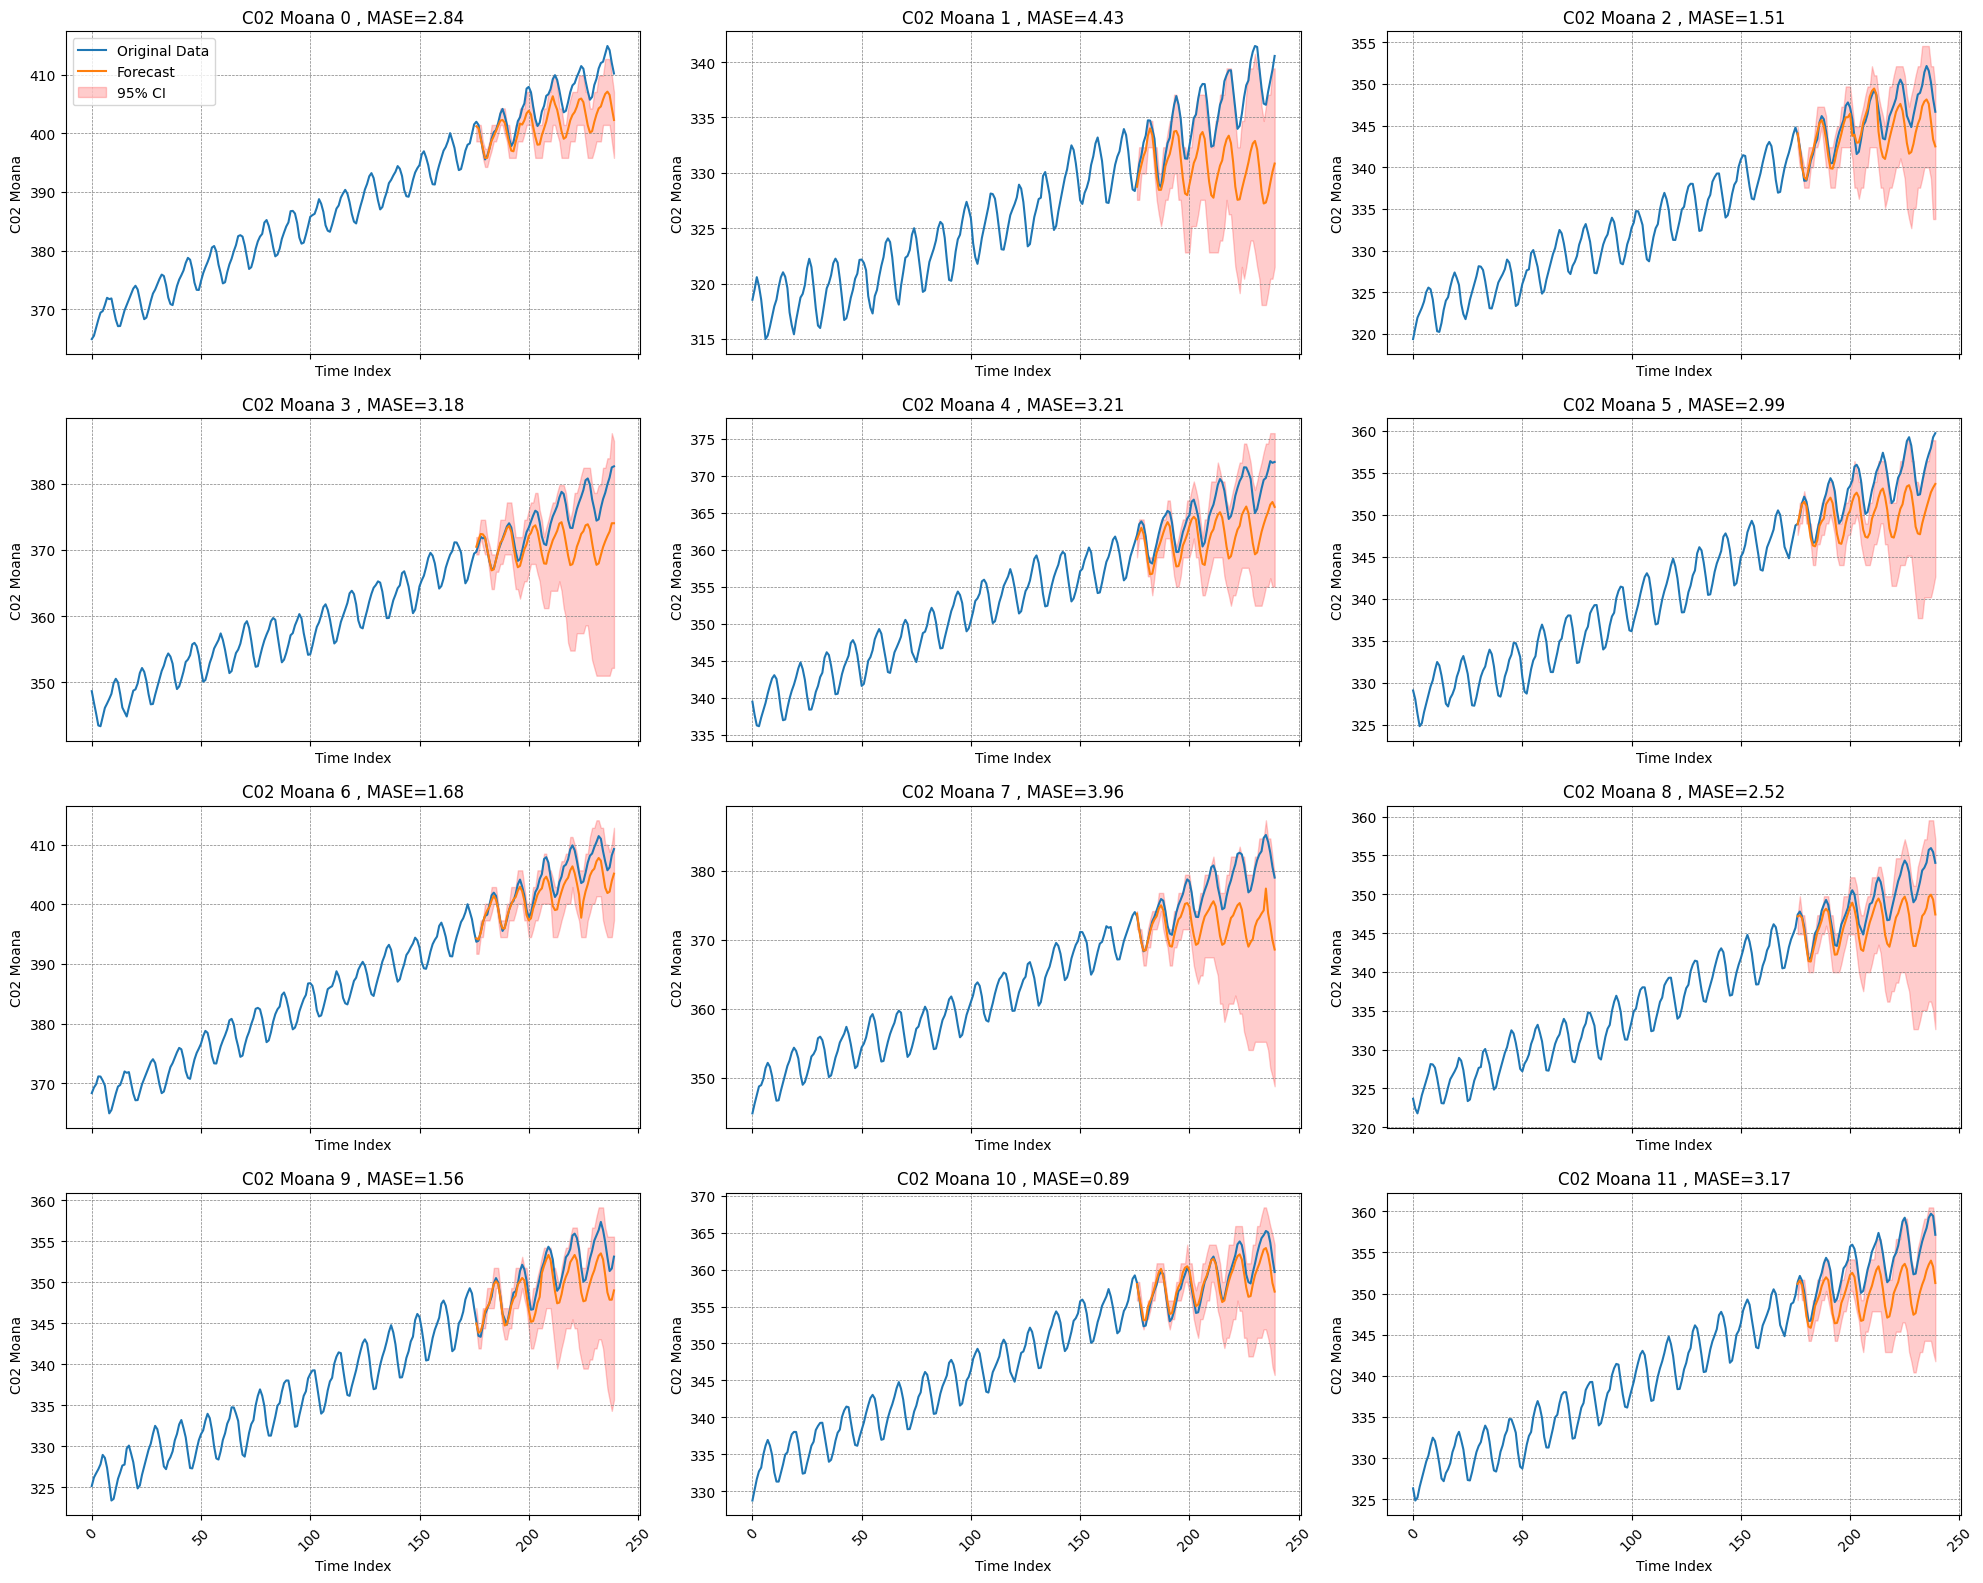

In [79]:
df_list,df_wide = reshape_time_series(df_co2,name_of_target="monthly-average", n_timeseries=n_timeseries, duration_years=20)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="C02 Moana",filename="./plots/CO2_forecast.png")


## Paleo Climate Benthic D018 time series

This time series is phenomenal because it shows how the system switches from 100ka cycle to 20-40ka cycles. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071

In [152]:
df_benthic = pd.read_csv("../data/cleaned_lr04.csv")
df_benthic.head()

Time-(ka)  Benthic-d18O-(per-mil)  Standard-error-(per-mil)
0        0.0                    3.23                      0.03
1        1.0                    3.23                      0.04
2        2.0                    3.18                      0.03
3        3.0                    3.29                      0.03
4        4.0                    3.30                      0.03

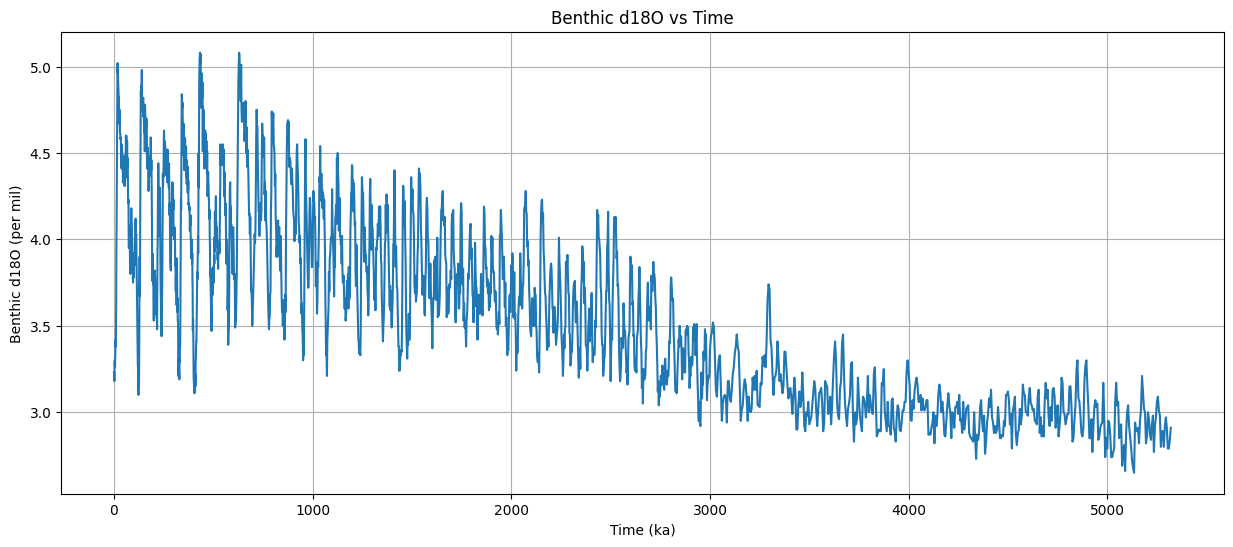

In [153]:
fig=plt.figure(figsize=(15, 6))
plt.plot(df_benthic["Time-(ka)"],df_benthic["Benthic-d18O-(per-mil)"])   
plt.xlabel("Time (ka)")
plt.ylabel("Benthic d18O (per mil)")
plt.title("Benthic d18O vs Time")
plt.grid() 

In [154]:
# add a time_index column to the dataframe
df_benthic["time_index"] = np.arange(len(df_benthic))
# remove Time-(ka) column
df_benthic = df_benthic.drop(columns=["Time-(ka)"])
# move the last to the first position
cols = df_benthic.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_benthic = df_benthic[cols]
df_benthic.head()


time_index  Benthic-d18O-(per-mil)  Standard-error-(per-mil)
0           0                    3.23                      0.03
1           1                    3.23                      0.04
2           2                    3.18                      0.03
3           3                    3.29                      0.03
4           4                    3.30                      0.03

In [155]:
df_benthic_copy.describe()

time_index     target_1  Standard-error-(per-mil)  forecast_0
count  1057.000000  1057.000000               1057.000000    64.00000
mean    528.000000     4.083623                  0.055941     3.80294
std     305.273921     0.425770                  0.016902     0.00000
min       0.000000     3.100000                  0.000000     3.80294
25%     264.000000     3.780000                  0.040000     3.80294
50%     528.000000     4.070000                  0.050000     3.80294
75%     792.000000     4.420000                  0.060000     3.80294
max    1056.000000     5.080000                  0.140000     3.80294

Mean Absolute Error (MAE) for target_1: 0.31216225504875184
Mean of forecast MAEs = 0.31216225504875184
Mean Absolute Scaled Error (MASE) for target_1: 2.6793218076391505
Mean of forecast MAEs = 2.6793218076391505
Mean of d/dt=0 MAEs = 0.41046875000000005
torch.Size([1, 50, 64])
torch.Size([64])
Mean of forecast MASEs = 2.6793218076391505
1
torch.Size([64])


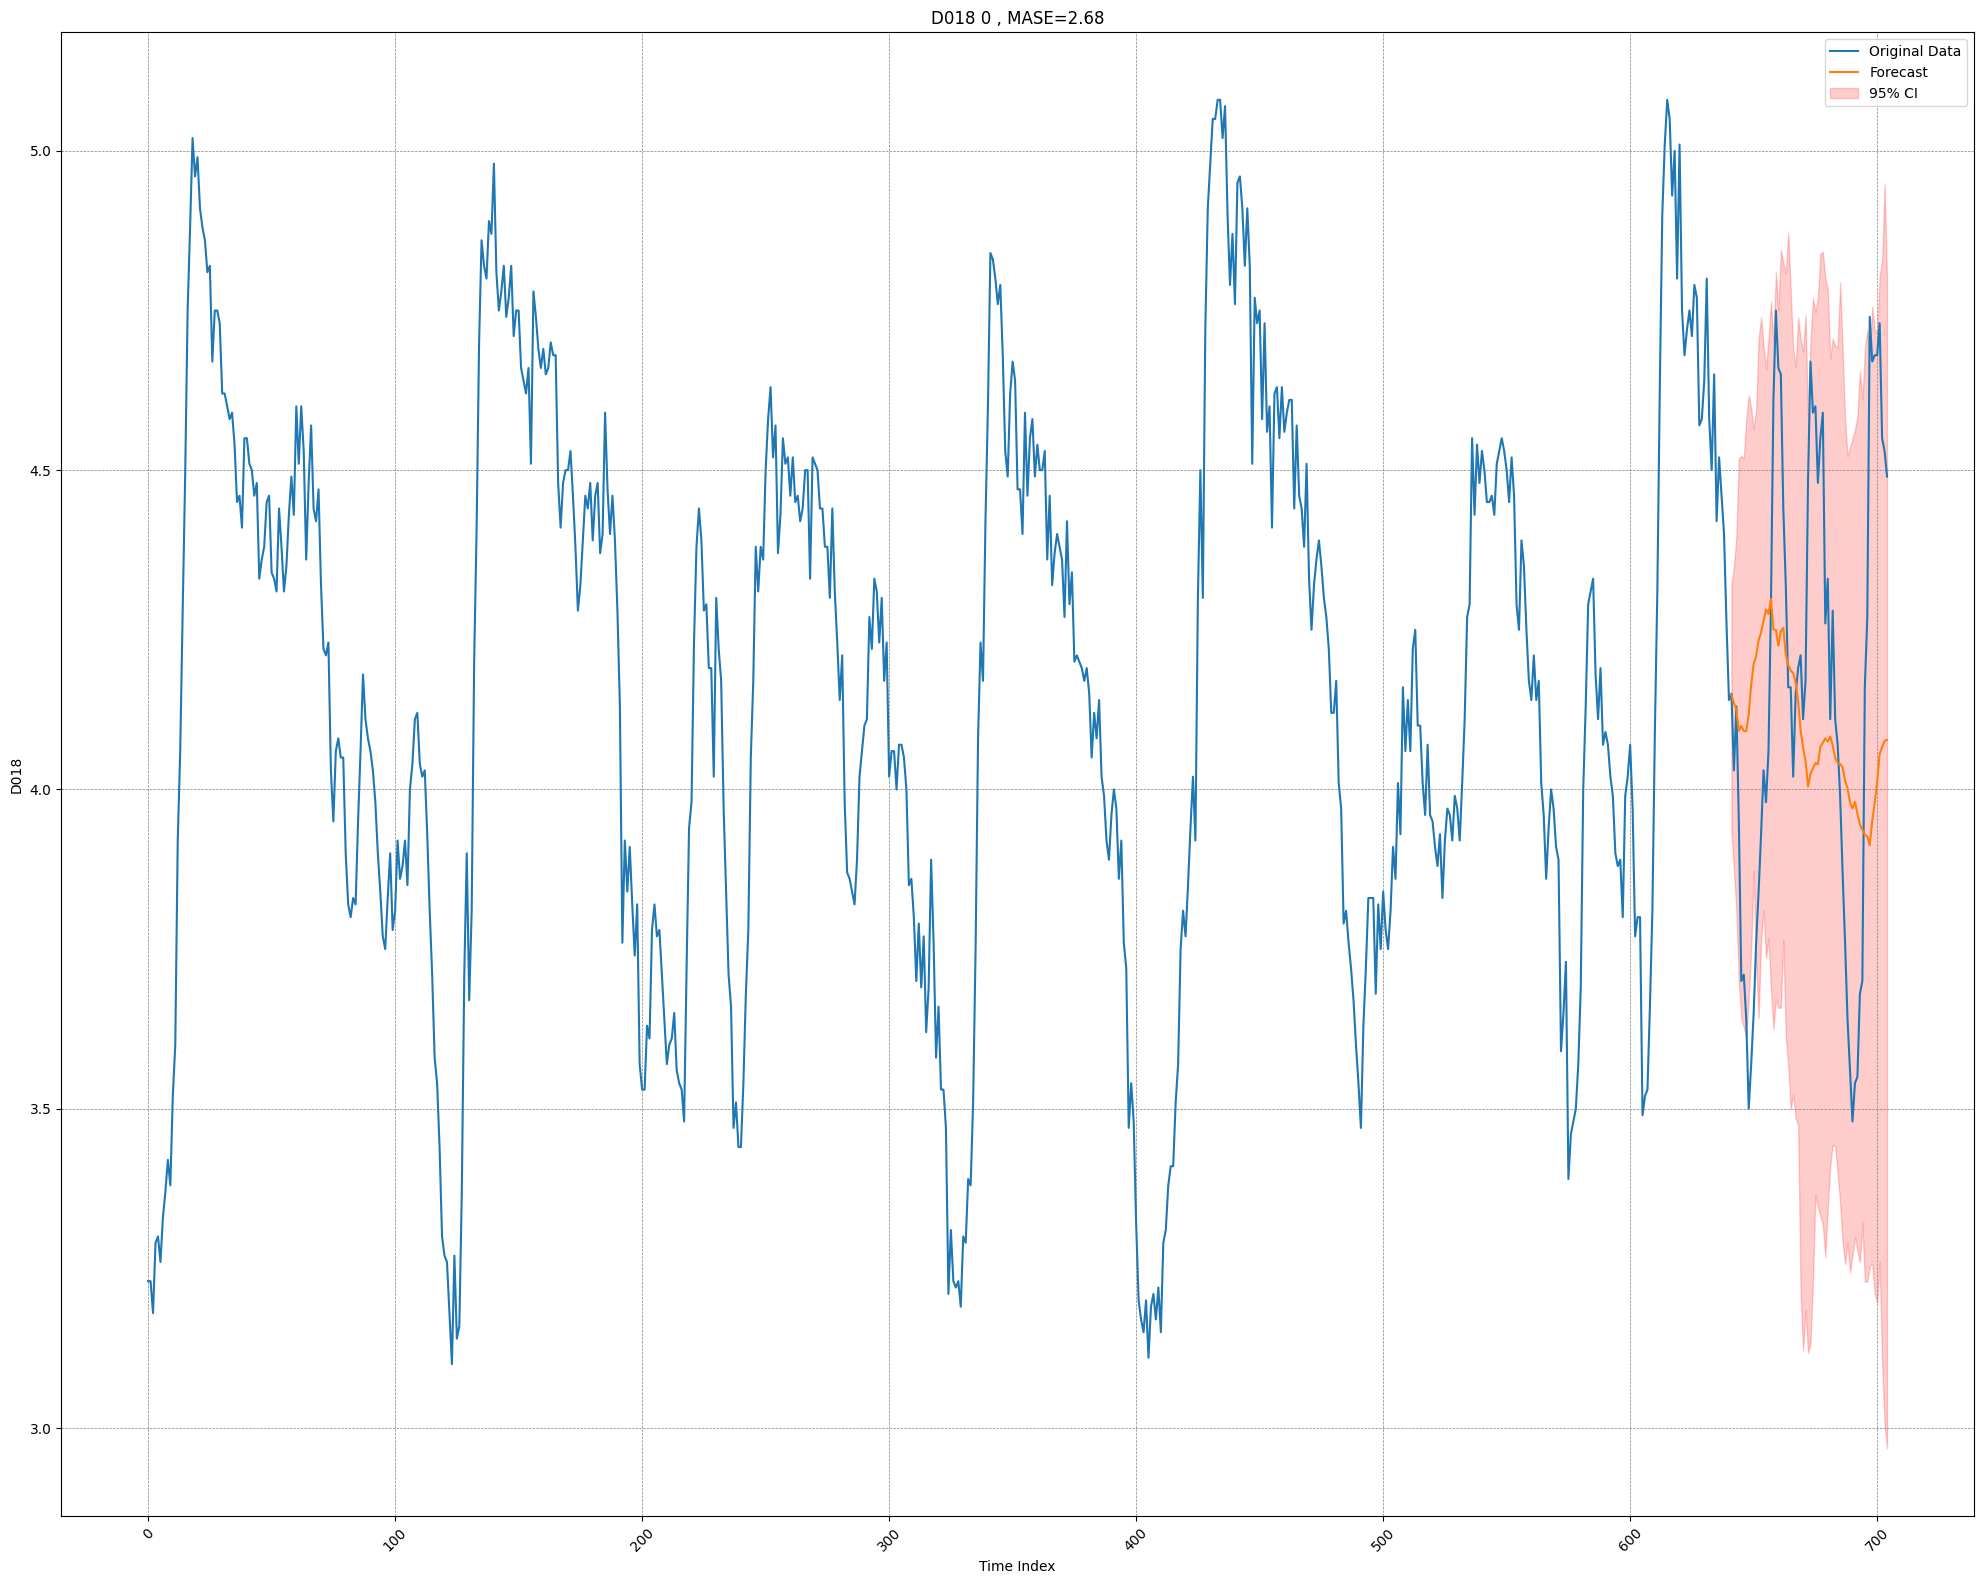

In [157]:
# now predict with chronos
df_benthic_copy = df_benthic.iloc[:len(df_benthic)//3]
# rename benthic-d18O-(per-mil) to target_1
df_benthic_copy = df_benthic_copy.rename(columns={"Benthic-d18O-(per-mil)":"target_1"})
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_benthic_copy,predict_length=64,n_timeseries=1)
# plot the forecast
plot_forecasts(df_benthic_copy,split_index,forecast,1,field="D018",filename="./plots/d018_forecast.png")
